In [1]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 

import numpy as np
import matplotlib.pyplot as plt
from hhl_algorithm import HHLAlgorithm as hhl
# from hhl_algorithm_1bit import HHLAlgorithm as hhl_1
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian
import itertools as it
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl

import itertools as it
import scipy.sparse as ss


In [ ]:
dz = 20 #mm
particle_sets = [[2],[2,1],[2,1,1], [2,1,1,1], [2,2,2,1,1]]
layer_sets = [2,3]


# n_particles=[5]#, 2, 2]#0, 20, 20, 20]
results = []


# 

for n_particles, layers in it.product(particle_sets, layer_sets):
    print(f'running simulation...{n_particles}, {layers}')
    n = np.sum(n_particles)
    N_p = np.sum(n_particles)
    N_L = layers
    events = len(n_particles)

    module_id = [l for l in range(1, layers+1)]
    lx = [33 for x in range(1, layers+1)]
    ly = [33 for x in range(1, layers+1)]
    zs = [dz*l for l in range(1, layers+1)]

    Detector = state_event_model.PlaneGeometry(module_id=module_id,lx = lx,ly = ly,z = zs)
    # Detector = state_event_model.RectangularVoidGeometry(module_id=module_id,lx = lx,ly = ly,z=zs, void_x_boundary=5, void_y_boundary=5)

    state_event_gen = StateEventGenerator(Detector, events = len(n_particles), n_particles=n_particles,
                                        measurement_error=0.0, collision_noise=0.00)
    state_event_gen.generate_random_primary_vertices({'x': 0, 'y': 0, 'z': 0})

    event_particles = []
    for event in range(events):
        particles_list = []
        for particle in range(n):
            particle_dict = {
                'type' : 'MIP',
                'mass': 0.511,
                'q': 1
            }
            particles_list.append(particle_dict)
        event_particles.append(particles_list)

    state_event_gen.generate_particles(event_particles)

    event_tracks = state_event_gen.generate_complete_events()

    # event_tracks.plot_segments()

    false_tracks = state_event_gen.make_noisy_event(drop_rate=0.0, ghost_rate=0.0)

    # false_tracks.plot_segments()

    ham = SimpleHamiltonian(epsilon=1e-7, gamma=2.0, delta=1.0)

    ham.construct_hamiltonian(event=event_tracks, convolution=False)
    classical_solution = ham.solve_classicaly()
    T = .45
    discretized_classical_solution = (classical_solution > T).astype(int)
    A = ham.A.todense()
    N_A = A.shape[0]

    #print eigenvalues of A and their algebraic multiplicities
    eigenvalues, multiplicities = np.unique(np.linalg.eigvals(A), return_counts=True)
    # for eig, mult in zip(eigenvalues, multiplicities):
    #     print(f"Eigenvalue: {eig}, Multiplicity: {mult}")
    vector_b = np.ones(len(A))
    hhl_solver = hhl(A, vector_b)
    circuit = hhl_solver.build_circuit()
    counts = hhl_solver.run()

    results.append(
        {
        'N_p': N_p,
        'N_L': N_L,
        'N_A': N_A,
        'N_Q': np.ceil(np.log2(N_A)),
        'e_vals' : eigenvalues,
        'alg_mult' : multiplicities,
        'N_s': N_p * (N_L-1),
        'spare_A_CSR' : ss.csr_matrix(A), 
        'all_evals': np.repeat(eigenvalues, multiplicities),
        'counts': counts,
        'cond_num': np.linalg.cond(A)
    }
)

running simulation...[2], 2
running simulation...[2], 3
running simulation...[2, 1], 2
running simulation...[2, 1], 3
running simulation...[2, 1, 1], 2
running simulation...[2, 1, 1], 3


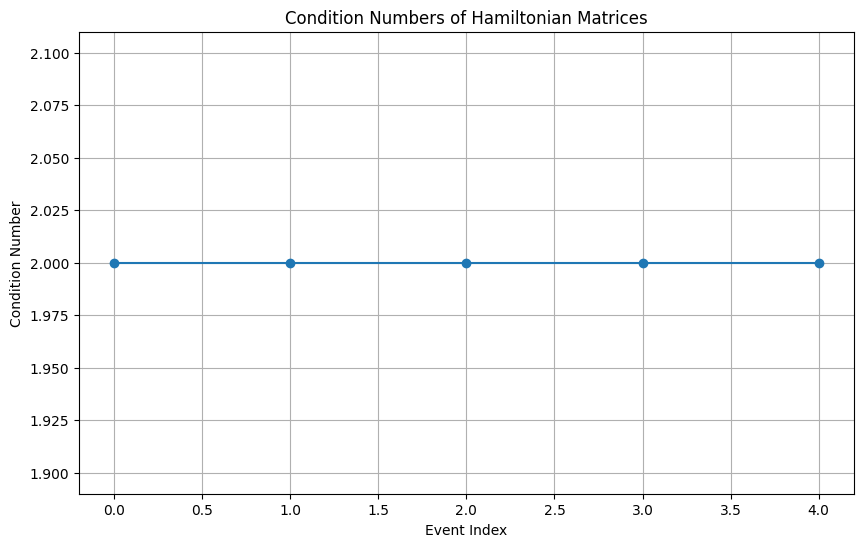

In [ ]:
cond_numbers = [results[i]['cond_num'] for i in range(len(results))]
plt.figure(figsize=(10, 6))
plt.plot(cond_numbers, marker='o')
plt.title('Condition Numbers of Hamiltonian Matrices')
plt.xlabel('Event Index')
plt.ylabel('Condition Number')
plt.grid()
plt.show()

C:\Users\GeorgeWilliam\AppData\Local\Temp\ipykernel_27984\4133024596.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


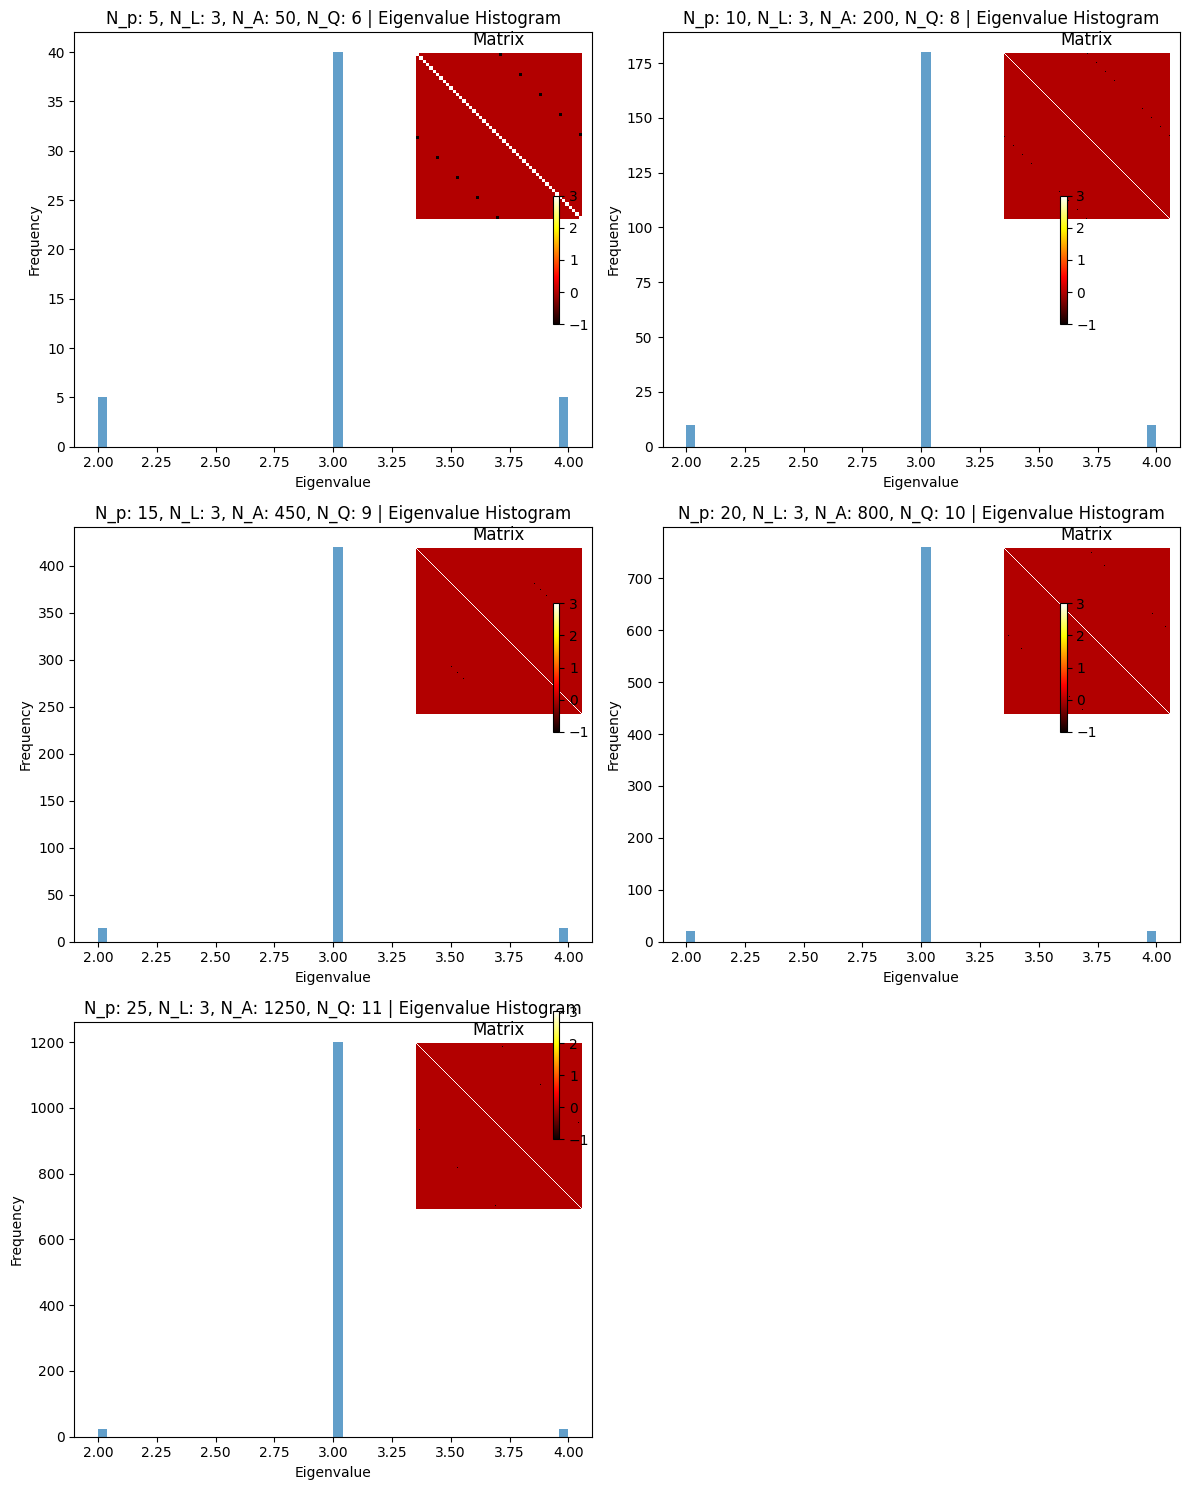

In [11]:
# Number of results
n_results = len(results)
ncols = 2
nrows = int(np.ceil(n_results / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
axes = axes.flatten()

for idx, r in enumerate(results):
    eigs = r['all_evals']
    matrix = r['spare_A_CSR'].todense()
    title = f"N_p: {r['N_p']}, N_L: {r['N_L']}, N_A: {r['N_A']}, N_Q: {int(r['N_Q'])}"

    # Eigenvalue histogram
    axes[idx].hist(eigs, bins=50, alpha=0.7, color='tab:blue')
    axes[idx].set_title(title + " | Eigenvalue Histogram")
    axes[idx].set_xlabel('Eigenvalue')
    axes[idx].set_ylabel('Frequency')

    # Overlay matrix heatmap as inset
    inset_ax = axes[idx].inset_axes([0.65, 0.55, 0.33, 0.4])
    im = inset_ax.imshow(matrix, cmap='hot', interpolation='nearest')
    inset_ax.set_title('Matrix')
    inset_ax.axis('off')
    fig.colorbar(im, ax=inset_ax, fraction=0.046, pad=0.04)

# Hide unused subplots
for ax in axes[n_results:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
events

2

In [8]:
event_particles

[[{'type': 'MIP', 'mass': 0.511, 'q': 1},
  {'type': 'MIP', 'mass': 0.511, 'q': 1},
  {'type': 'MIP', 'mass': 0.511, 'q': 1},
  {'type': 'MIP', 'mass': 0.511, 'q': 1},
  {'type': 'MIP', 'mass': 0.511, 'q': 1}]]

In [ ]:

print(np.shape(A))

(50, 50)


In [34]:
# find A eigne values and multiplicities
from scipy.sparse.linalg import eigs
eigenvalues, eigenvectors = eigs(ham.A)
print("Eigenvalues:", eigenvalues)
multiplicies = np.bincount(np.abs(eigenvalues.astype(int)))
print("Multiplicities:", multiplicies)

Eigenvalues: [3.+0.j 4.+0.j 4.+0.j 4.+0.j 4.+0.j 4.+0.j]
Multiplicities: [0 0 0 2 4]


C:\Users\GeorgeWilliam\AppData\Local\Temp\ipykernel_30060\3243695065.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  multiplicies = np.bincount(np.abs(eigenvalues.astype(int)))


In [38]:
# give me a sparse description of A
from scipy.sparse import csr_matrix
A_sparse = csr_matrix(A)
print("Sparse matrix representation of A:")
print(A_sparse)

# coords of -1s
coords = np.argwhere(A == -1)
print("Coordinates of -1s in A:")
for coord in coords:
    print(f"Row: {coord[0]}, Column: {coord[1]}")

Sparse matrix representation of A:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 60 stored elements and shape (50, 50)>
  Coords	Values
  (0, 0)	3.0
  (0, 25)	-1.0
  (1, 1)	3.0
  (2, 2)	3.0
  (3, 3)	3.0
  (4, 4)	3.0
  (5, 5)	3.0
  (6, 6)	3.0
  (6, 31)	-1.0
  (7, 7)	3.0
  (8, 8)	3.0
  (9, 9)	3.0
  (10, 10)	3.0
  (11, 11)	3.0
  (12, 12)	3.0
  (12, 37)	-1.0
  (13, 13)	3.0
  (14, 14)	3.0
  (15, 15)	3.0
  (16, 16)	3.0
  (17, 17)	3.0
  (18, 18)	3.0
  (18, 43)	-1.0
  (19, 19)	3.0
  (20, 20)	3.0
  :	:
  (29, 29)	3.0
  (30, 30)	3.0
  (31, 6)	-1.0
  (31, 31)	3.0
  (32, 32)	3.0
  (33, 33)	3.0
  (34, 34)	3.0
  (35, 35)	3.0
  (36, 36)	3.0
  (37, 12)	-1.0
  (37, 37)	3.0
  (38, 38)	3.0
  (39, 39)	3.0
  (40, 40)	3.0
  (41, 41)	3.0
  (42, 42)	3.0
  (43, 18)	-1.0
  (43, 43)	3.0
  (44, 44)	3.0
  (45, 45)	3.0
  (46, 46)	3.0
  (47, 47)	3.0
  (48, 48)	3.0
  (49, 24)	-1.0
  (49, 49)	3.0
Coordinates of -1s in A:
Row: 0, Column: 25
Row: 6, Column: 31
Row: 12, Column: 37
Row: 18, Column: 43
Row:

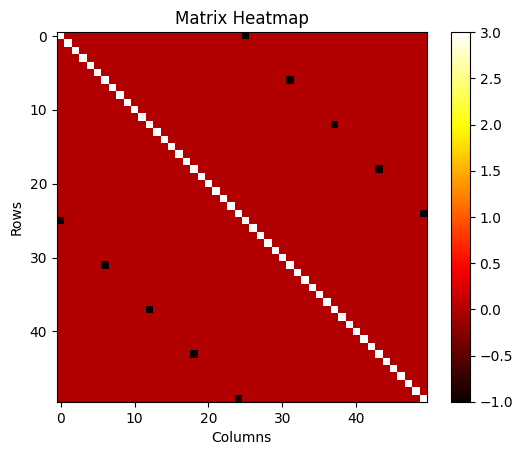

In [35]:
# matrix heat map
plt.imshow(A, cmap='hot', interpolation='nearest')
plt.colorbar()  
plt.title('Matrix Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

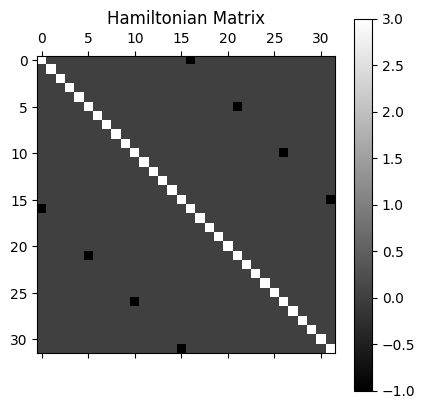

In [17]:

plt.matshow(A, cmap='gray')
plt.colorbar()
plt.title('Hamiltonian Matrix')
plt.show()

In [18]:
import scipy as sci
#rank_A = np.linalg.matrix_rank(A)
#print(f"\nRank of matrix A: {rank_A}")
print(np.abs(np.linalg.eigvals(A)))

[4. 2. 4. 2. 4. 2. 4. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3.]


In [ ]:
print("HHL Algorithm Implementation")
print("=" * 60)

matrix_A = A
vector_b = np.ones(len(A))

print("\nSolving Ax = b with:")
print("A =")
print(matrix_A)
print("b =")
print(vector_b)

from hhl_algorithm_1bit import add_suzuki_trotter_to_class
hhl_1 = add_suzuki_trotter_to_class(hhl_1)

# Create an instance of the HHL algorithm.
hhl_solver = hhl_1(matrix_A, vector_b, num_time_qubits=1, shots=10000)
circuit = hhl_solver.build_circuit()
print("\nHHL Circuit:")
print(circuit.draw(output="text"))

# Run the circuit.
counts = hhl_solver.run()
print("\nRaw Measurement Counts:")
print(counts)

# # Plot the histogram of all measurement results.
# hhl_solver.plot_results("hhl_results.png")

# Extract the HHL solution (trimmed to the original dimension).
x_hhl = hhl_solver.get_solution()
print("\nExtracted HHL solution (normalized):")
print(x_hhl)

# Compute the theoretical solution for comparison (using the original system, not the padded one).
x_exact = np.linalg.solve(matrix_A, vector_b)
#x_exact_normalized = x_exact / np.linalg.norm(x_exact)
print("\nTheoretical solution (normalized):")
print(x_exact)

HHL Algorithm Implementation

Solving Ax = b with:
A =
[[ 3.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  3.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  3.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  3.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  3.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  3.]]
b =
[1. 1. 1. 1. 1. 1. 1. 1.]
Patching HHLAlgorithm with Suzuki-Trotter methods...
0.0
4.0

HHL Circuit:
         ┌───┐           C-Trot(t=0.8)            ┌──────┐┌───┐         ┌───┐»
   time: ┤ H ├─────────────────■──────────────────┤ IQFT ├┤ X ├────■────┤ X ├»
         ├───┤┌────────────────┴─────────────────┐└──────┘└───┘    │    └───┘»
    b_0: ┤ H ├┤0                                 ├─────────────────┼─────────»
         ├───┤│                                  │                 │         »
    b_1: ┤ H ├┤1 exp(-it (III + XII + XZZ))(π/4) ├─────────────────┼─────────»
         ├───┤│                                  │                 │         »
    b_

<string>:14: RuntimeWarning: divide by zero encountered in scalar divide



Raw Measurement Counts:
{'1011': 185, '1111': 665, '1101': 187, '0011': 196, '0001': 611, '0101': 180, '1010': 1128, '1110': 570, '0100': 1084, '1100': 1053, '1000': 601, '0110': 639, '0000': 587, '0010': 1058, '1001': 641, '0111': 615}
Outcome: 1011, Count: 185
Outcome: 1111, Count: 665
Outcome: 1101, Count: 187
Outcome: 0011, Count: 196
Outcome: 0001, Count: 611
Outcome: 0101, Count: 180
Outcome: 1001, Count: 641
Outcome: 0111, Count: 615

Extracted HHL solution (normalized):
[0.43160223 0.2444506  0.23426064 0.4330127  0.44207107 0.23749198
 0.23877227 0.45027092]

Theoretical solution (normalized):
[0.5        0.33333333 0.33333333 0.5        0.5        0.33333333
 0.33333333 0.5       ]


In [ ]:
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks

truth_event = false_tracks
rec_tracks = get_tracks(ham, discretized_classical_solution, false_tracks) 

from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
validator = evl(truth_event, rec_tracks)
validator.print_metrics()

In [ ]:
'''from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='20caa5a0277cbbb8949d9d9dbe38669d2a916493d36b2920d6d9d6d409addc73167334f2a5ec06736887b565c2c0f20aabc250aa773f6dcaef80e10fd68ce5a6'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBM Quantum API key>')
backend = service.least_busy(min_num_qubits=circuit.num_qubits, simulator=False, operational=True)
print(f"Found device: '{backend.name}'")
print(f"Status: {backend.status().status_msg}, Qubits: {backend.num_qubits}, Pending Jobs: {backend.status().pending_jobs}")'''

'from qiskit_ibm_runtime import QiskitRuntimeService\n\nservice = QiskitRuntimeService(\n    channel=\'ibm_quantum\',\n    instance=\'ibm-q/open/main\',\n    token=\'20caa5a0277cbbb8949d9d9dbe38669d2a916493d36b2920d6d9d6d409addc73167334f2a5ec06736887b565c2c0f20aabc250aa773f6dcaef80e10fd68ce5a6\'\n)\n\n# Or save your credentials on disk.\n# QiskitRuntimeService.save_account(channel=\'ibm_quantum\', instance=\'ibm-q/open/main\', token=\'<IBM Quantum API key>\')\nbackend = service.least_busy(min_num_qubits=circuit.num_qubits, simulator=False, operational=True)\nprint(f"Found device: \'{backend.name}\'")\nprint(f"Status: {backend.status().status_msg}, Qubits: {backend.num_qubits}, Pending Jobs: {backend.status().pending_jobs}")'

In [1]:
import os
from qiskit import transpile
from qiskit.visualization import plot_histogram
# The new pattern uses SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# Make sure a QuantumCircuit object named 'circuit' exists from your previous cell.
if 'circuit' not in locals():
    raise NameError("A Qiskit QuantumCircuit object named 'circuit' was not found. Please run your HHL code cell first.")

print("--- Step 1: Connecting to IBM Quantum using IBM Cloud Channel ---")
try:
    # This will load your saved IBM Cloud credentials.
    # Make sure you have run QiskitRuntimeService.save_account(channel='ibm_cloud', ...)
    service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='20caa5a0277cbbb8949d9d9dbe38669d2a916493d36b2920d6d9d6d409addc73167334f2a5ec06736887b565c2c0f20aabc250aa773f6dcaef80e10fd68ce5a6')
    print("Successfully connected to the Qiskit Runtime Service.")
except Exception as e:
    print(f"Failed to connect: {e}")
    print("Please ensure you have saved your IBM Cloud API Key and CRN.")

if 'service' in locals():
    print("\n--- Step 2: Finding the Best Available Device ---")
    # Find the least busy backend that is not a simulator and has enough qubits
    backend = service.least_busy(min_num_qubits=circuit.num_qubits, simulator=False, operational=True)
    print(f"Found device: '{backend.name}'")
    print(f"Status: {backend.status().status_msg}, Qubits: {backend.num_qubits}, Pending Jobs: {backend.status().pending_jobs}")

    print("\n--- Step 3: Estimating Circuit Depth and Gate Counts ---")
    print(f"Transpiling circuit for '{backend.name}'...")

    # Transpile the circuit for the specific hardware backend
    transpiled_circuit = transpile(circuit, backend=backend, optimization_level=3, translation_method='translator')

    print("\n--- Comparison of Circuit Metrics ---")
    print(f"Transpiled Circuit Depth (for '{backend.name}'): {transpiled_circuit.depth()}")
    print(f"Transpiled Gate Counts: {transpiled_circuit.count_ops()}")
    print("-" * 40)

    print("\n--- Step 4: Running the Circuit using SamplerV2 ---")
    print("WARNING: This will submit a job to the IBM Quantum cloud.")
    
    # Add measurements if your circuit doesn't have them
    if transpiled_circuit.num_clbits == 0:
        print("Adding measurement gates to the circuit...")
        transpiled_circuit.measure_all(inplace=True)

    # --- MODIFIED CODE BLOCK for SamplerV2 ---
    # 1. Instantiate the Sampler with the chosen backend
    sampler = Sampler(mode=backend)
    
    # 2. Submit the job by calling sampler.run()
    #    The 'shots' count is passed as a direct argument.
    job = sampler.run([transpiled_circuit], shots=16384)
    # --- END MODIFICATION ---
    
    print(f"Job submitted successfully. Job ID: {job.job_id}")
    print(f"You can monitor the job status here: https://quantum.ibm.com/jobs/{job.job_id}")
    
    print("\nWaiting for job to complete... (This can take a long time)")
    result = job.result()
    
    print("\nJob finished!")
    # The V2 result object contains the data in a pub_result (Primitive Unified Bloc Result)
    # We access the counts from the data field of the first result.
    pub_result = result[0]
    counts = pub_result.data.c.get_counts()

    print("\n--- Measurement Results from Hardware ---")
    print(counts)
    plot_histogram(counts)

NameError: A Qiskit QuantumCircuit object named 'circuit' was not found. Please run your HHL code cell first.

In [272]:
x_hhl = hhl_solver.get_solution(counts)
print("\nExtracted HHL solution (normalized):")
print(x_hhl)

Outcome: 1101, Count: 1081
Outcome: 0111, Count: 910
Outcome: 1111, Count: 890
Outcome: 1011, Count: 956
Outcome: 1001, Count: 1559
Outcome: 0011, Count: 1020
Outcome: 0001, Count: 1583
Outcome: 0101, Count: 1253

Extracted HHL solution (normalized):
[0.41364011 0.33203378 0.36800839 0.31361937 0.41049252 0.3214483
 0.34181808 0.31015386]


In [254]:
x_exact_disc = (x_exact > 0.4).astype(int)
x_hhl_disc = (x_hhl > 0.0).astype(int)

num_matches = np.sum(x_exact_disc == x_hhl_disc)
total_elements = len(x_exact_disc)
similarity_accuracy = num_matches / total_elements
print(f"Similarity (Accuracy): {similarity_accuracy:.4f}")

from scipy.spatial.distance import hamming
hamming_distance_norm_scipy = hamming(x_exact_disc, x_hhl_disc)
print(f"Hamming Distance: {hamming_distance_norm_scipy:.4f}")

Similarity (Accuracy): 1.0000
Hamming Distance: 0.0000


In [255]:
circuit_depth = circuit.decompose().decompose().decompose().decompose().decompose().decompose().count_ops()
circuit_depth

OrderedDict([('u', 276), ('cx', 146), ('measure', 4)])

--- INSIDE analyze_solution_spectrum ---
Initial shape of matrix_A: (8, 8)
Initial shape of vector_b: (8,)
Shape of vector_b after flattening: (8,)
-------------------------------------

--- Loop iteration i=0 ---
Eigenvalue (key): 4.00
Shape of component_solutions[key] (left side of +=): (8,)
Shape of component (right side of +=):            (8,)
4.0
[ 0.70710678  0.          0.          0.         -0.70710678  0.
  0.          0.        ]
...addition successful.

--- Loop iteration i=1 ---
Eigenvalue (key): 2.00
Shape of component_solutions[key] (left side of +=): (8,)
Shape of component (right side of +=):            (8,)
2.0
[0.70710678 0.         0.         0.         0.70710678 0.
 0.         0.        ]
...addition successful.

--- Loop iteration i=2 ---
Eigenvalue (key): 4.00
Shape of component_solutions[key] (left side of +=): (8,)
Shape of component (right side of +=):            (8,)
4.0
[ 0.          0.          0.         -0.70710678  0.          0.
  0.          0.7071067

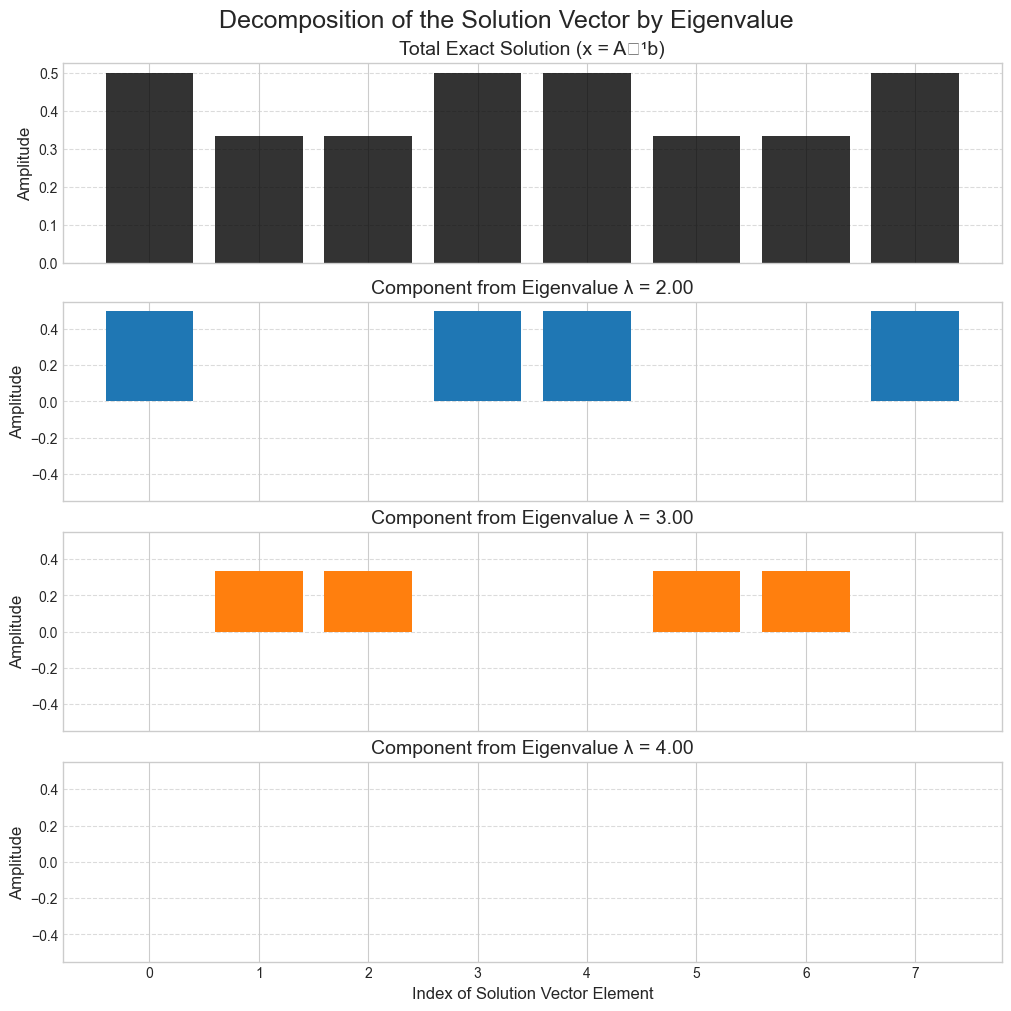

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_solution_spectrum(matrix_A, vector_b):
    """
    Classically computes the exact solution to Ax=b and decomposes it
    into components based on the eigenvalues of A, with added debugging prints.
    """
    print("--- INSIDE analyze_solution_spectrum ---")
    print(f"Initial shape of matrix_A: {matrix_A.shape}")
    print(f"Initial shape of vector_b: {vector_b.shape}")

    # --- ROBUSTNESS FIX ---
    # Ensure the input vector is a 1D array ('flattened').
    vector_b = vector_b.flatten()
    print(f"Shape of vector_b after flattening: {vector_b.shape}")
    print("-------------------------------------\n")


    if matrix_A.shape[0] != matrix_A.shape[1]:
        raise ValueError("Matrix A must be square.")
    if matrix_A.shape[0] != len(vector_b):
        raise ValueError("Matrix and vector dimensions must match.")

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eig(matrix_A)
    #print('Eingenvalues:', eig_vals)
    #print('Eingenvectors:', eig_vecs)
    # Change of basis
    betas = np.linalg.inv(eig_vecs) @ vector_b

    # Prepare for component calculation
    unique_eigenvalues = np.unique(np.round(eig_vals, 5))
    component_solutions = {lam: np.zeros_like(vector_b, dtype=complex) for lam in unique_eigenvalues}

    # Calculate individual solution components
    for i in range(len(eig_vals)):
        lam = eig_vals[i]
        beta = betas[i]
        u_vec = eig_vecs[:, i]
        
        key = unique_eigenvalues[np.argmin(np.abs(unique_eigenvalues - lam))]
        
        if abs(lam) > 1e-9:
            component = (beta / lam) * u_vec
            
            # --- DEBUGGING PRINT STATEMENTS ---
            print(f"--- Loop iteration i={i} ---")
            print(f"Eigenvalue (key): {key:.2f}")
            print(f"Shape of component_solutions[key] (left side of +=): {component_solutions[key].shape}")
            print(f"Shape of component (right side of +=):            {component.shape}")
            print(lam)
            print(u_vec)
            
            # This is the line that causes the error
            component_solutions[key] += component
            
            print("...addition successful.\n")


    # Calculate the total solution for comparison
    total_exact_solution = np.linalg.solve(matrix_A, vector_b)

    # Plotting
    num_plots = len(unique_eigenvalues) + 1
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, num_plots * 2.5), sharex=True, constrained_layout=True)
    fig.suptitle('Decomposition of the Solution Vector by Eigenvalue', fontsize=18)

    axes[0].bar(range(len(total_exact_solution)), total_exact_solution.real, color='black', alpha=0.8)
    axes[0].set_title('Total Exact Solution (x = A⁻¹b)', fontsize=14)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    plot_idx = 1
    max_comp_amp = max([np.max(np.abs(comp.real)) for comp in component_solutions.values()] + [0])
    if max_comp_amp == 0: max_comp_amp = 1.0

    for lam, component_vec in sorted(component_solutions.items()):
        ax = axes[plot_idx]
        ax.bar(range(len(component_vec)), component_vec.real, color=f'C{plot_idx-1}')
        ax.set_title(f'Component from Eigenvalue λ = {lam:.2f}', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim(-max_comp_amp * 1.1, max_comp_amp * 1.1)
        plot_idx += 1

    axes[-1].set_xlabel('Index of Solution Vector Element', fontsize=12)
    plt.show()

    
analyze_solution_spectrum(np.array(matrix_A), np.array(vector_b))

In [257]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit import transpile

# Assume 'circuit' is your fully built QuantumCircuit object from hhl_solver.build_circuit()

print("\n--- Transpiling for a specific IBM Quantum device ---")

# 1. Load a realistic model of the target backend.
# FakeSherbrooke mimics the real 127-qubit device's properties.

backend = FakeSherbrooke()
print(f"Loaded realistic model for: {backend.name}")
print(f"Number of qubits: {backend.configuration().n_qubits}")
print(f"Basis gates: {backend.configuration().basis_gates}")

# 2. Transpile the circuit for the backend with high optimization.
# The transpiler will now account for the specific gate set and qubit connectivity.
print("\nTranspiling... (This may take a moment for a large circuit)")
transpiled_circuit_sherbrooke = transpile(circuit, backend=backend, optimization_level=3)

# 3. Analyze the new, hardware-aware circuit
real_depth = transpiled_circuit_sherbrooke.depth()
real_gate_counts = transpiled_circuit_sherbrooke.count_ops()

print("\n--- Results for ibm_sherbrooke ---")
print(f"Real Circuit Depth: {real_depth}")
print("Real Gate Counts:", real_gate_counts)


# Assume 'circuit' and 'backend' (e.g., FakeSherbrooke) exist

print("--- Searching for a better transpilation seed ---")
best_circuit = None
best_depth = float('inf')

for seed in range(5): # Try 5 different random seeds
	print(f"Trying seed_transpiler = {seed}...")
	transpiled = transpile(circuit, 
						backend=backend, 
						optimization_level=3,
						layout_method='sabre', # Explicitly state the method
						routing_method='sabre',
						seed_transpiler=seed) # Use a different seed each time
	
	current_depth = transpiled.depth()
	print(f"  -> Achieved depth: {current_depth}")
	
	if current_depth < best_depth:
		best_depth = current_depth
		best_circuit = transpiled

print(f"\nBest depth found after 5 attempts: {best_depth}")
print("Gate counts for best circuit:", best_circuit.count_ops())


--- Transpiling for a specific IBM Quantum device ---
Loaded realistic model for: fake_sherbrooke
Number of qubits: 127
Basis gates: ['ecr', 'id', 'rz', 'sx', 'x']

Transpiling... (This may take a moment for a large circuit)

--- Results for ibm_sherbrooke ---
Real Circuit Depth: 898
Real Gate Counts: OrderedDict({'rz': 728, 'sx': 459, 'ecr': 242, 'x': 46, 'measure': 4})
--- Searching for a better transpilation seed ---
Trying seed_transpiler = 0...
  -> Achieved depth: 924
Trying seed_transpiler = 1...
  -> Achieved depth: 937
Trying seed_transpiler = 2...
  -> Achieved depth: 953
Trying seed_transpiler = 3...
  -> Achieved depth: 914
Trying seed_transpiler = 4...
  -> Achieved depth: 911

Best depth found after 5 attempts: 911
Gate counts for best circuit: OrderedDict({'rz': 745, 'sx': 457, 'ecr': 258, 'x': 38, 'measure': 4})


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from hhl_algorithm import HHLAlgorithm as hhl
from hhl_algorithm_1bit import HHLAlgorithm as hhl_1
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
import itertools as it

--- All 16 Final States of the 4-Qubit System ---
OrderedDict({'u': 44, 'cx': 20, 'barrier': 2})
State |ancilla, main>  | Amplitude
--------------------|----------------------
   |0000>         | -0.0000 + 0.0000j
   |0001>         | 0.3536 + 0.0000j
   |0010>         | 0.3536 + 0.0000j
   |0011>         | 0.3536 + 0.0000j
   |0100>         | 0.3536 + 0.0000j
   |0101>         | 0.3536 + 0.0000j
   |0110>         | 0.3536 + 0.0000j
   |0111>         | 0.3536 + 0.0000j
   |1000>         | 0.3536 + 0.0000j
   |1001>         | 0.0000 + 0.0000j
   |1010>         | -0.0000 + 0.0000j
   |1011>         | 0.0000 + 0.0000j
   |1100>         | -0.0000 + 0.0000j
   |1101>         | -0.0000 + 0.0000j
   |1110>         | -0.0000 + 0.0000j
   |1111>         | 0.0000 + 0.0000j


In [259]:
# --- Constants ---
dz = 20  # mm layer spacing
layers = 5
n_particles = [20, 20, 20, 20, 20]
events = len(n_particles)
n = np.sum(n_particles)

# Detector configuration
module_id = list(range(1, layers + 1))
lx = [33] * layers
ly = [33] * layers
zs = [dz * l for l in range(1, layers + 1)]

# Noise and error parameters
measurement_errors = collision_noises = ghost_rates = drop_rates = np.round(np.linspace(0.00, 0.10, 11), 2)

# Results container
results = []

# --- Main parameter sweep ---
print("Starting parameter sweep...")

for mes_error, coll_noise, ghost, drop in it.product(measurement_errors, collision_noises, ghost_rates, drop_rates):
    print(f"\nRunning simulation with:")
    print(f"  Measurement error = {mes_error}")
    print(f"  Collision noise   = {coll_noise}")
    print(f"  Ghost rate        = {ghost}")
    print(f"  Drop rate         = {drop}")

    # --- Detector setup ---
    Detector = state_event_model.PlaneGeometry(
        module_id=module_id, lx=lx, ly=ly, z=zs
    )

    # --- State event generator setup ---
    state_event_gen = StateEventGenerator(
        Detector,
        events=events,
        n_particles=n_particles,
        measurement_error=mes_error,
        collision_noise=coll_noise
    )

    state_event_gen.generate_random_primary_vertices({'x': 1, 'y': 1, 'z': 1})

    event_particles = [[{'type': 'MIP', 'mass': 0.511, 'q': 1} for _ in range(n)] for _ in range(events)]

    state_event_gen.generate_particles(event_particles)
    event_tracks = state_event_gen.generate_complete_events()

    # --- Inject noise into events ---
    false_tracks = state_event_gen.make_noisy_event(drop_rate=drop, ghost_rate=ghost)

    # --- Hamiltonian setup and solve ---
    ham = SimpleHamiltonian(epsilon=1e-7, gamma=2.0, delta=1.0)
    ham.construct_hamiltonian(event=event_tracks, convolution=True)

    print("Solving classical Hamiltonian...")
    classical_solution = ham.solve_classicaly()
    discretized_solution = (classical_solution > 0.45).astype(int)

    # --- Track reconstruction and validation ---
    rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
    validator = evl(false_tracks, rec_tracks)
    metrics = validator.compute_metrics()

    print(f"  -> Metrics: {metrics}")

    # --- Store result ---
    results.append({
        'measurement_error': mes_error,
        'collision_noise': coll_noise,
        'ghost_rate': ghost,
        'drop_rate': drop,
        'metrics': metrics
    })

print("\nParameter sweep completed. Saving results...")

# --- Save results to JSON file ---
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Results saved to 'results.json'.")

Starting parameter sweep...

Running simulation with:
  Measurement error = 0.0
  Collision noise   = 0.0
  Ghost rate        = 0.0
  Drop rate         = 0.0
Solving classical Hamiltonian...
  -> Metrics: {'ghost_rate': 0.0, 'clone_fraction': 0.0, 'reconstruction_efficiency': 0.0, 'hit_efficiency': 0.0, 'purity': 0.0, 'total_rec_tracks': 0, 'total_truth_tracks': 100, 'ghost_tracks': [], 'clones_count': 0}

Running simulation with:
  Measurement error = 0.0
  Collision noise   = 0.0
  Ghost rate        = 0.0
  Drop rate         = 0.01


In [263]:
'''hhl_1 = add_suzuki_trotter_to_class(hhl_1)

hhl_solver = hhl_1(matrix_A, vector_b, num_time_qubits=2, shots=8192, debug=True)
circuit = hhl_solver.build_circuit()
print(circuit.draw(output="text"))
counts = hhl_solver.run()
print('counts:', counts)
#hhl_solver.plot_results("hhl_results.png")
x_hhl = hhl_solver.get_solution()
print("\nHHL Solution:", x_hhl)

x_exact = np.linalg.solve(matrix_A, vector_b)
x_exact_normalized = x_exact / np.linalg.norm(x_exact)
print("\nExact Solution:", x_exact_normalized)

if x_hhl is not None:
	fidelity = np.abs(np.vdot(x_hhl, x_exact_normalized))
	print(f"\nFidelity with exact solution: {fidelity:.4f}")

circuit_depth = circuit.decompose().decompose().decompose().decompose().decompose().decompose().depth()
gate_statistics = circuit.decompose().decompose().decompose().decompose().decompose().decompose().count_ops()
print(f"The depth of the quantum circuit is: {circuit_depth}")
print("Gate statistics for the circuit:")
print(gate_statistics)

#print("\nEigenvalues of original A:", np.round(hhl_solver.eigenvalues, 4))
#print("Eigenvalues of scaled A (used in phase estimation):", np.round(hhl_solver.eigenvalues_scaled, 4))

#print("\n[Debug] Running ideal statevector simulation...")
statevector = hhl_solver.simulate_statevector()
#print("Final statevector (truncated):", statevector.data[:8])

post_selected = hhl_solver.extract_postselected_solution(statevector)
#print("\nPostselected solution from statevector:", post_selected)
fidelity_post = np.abs(np.vdot(post_selected, x_exact_normalized))
#print(f"Fidelity (postselected vs exact): {fidelity_post:.4f}")'''


'hhl_1 = add_suzuki_trotter_to_class(hhl_1)\n\nhhl_solver = hhl_1(matrix_A, vector_b, num_time_qubits=2, shots=8192, debug=True)\ncircuit = hhl_solver.build_circuit()\nprint(circuit.draw(output="text"))\ncounts = hhl_solver.run()\nprint(\'counts:\', counts)\n#hhl_solver.plot_results("hhl_results.png")\nx_hhl = hhl_solver.get_solution()\nprint("\nHHL Solution:", x_hhl)\n\nx_exact = np.linalg.solve(matrix_A, vector_b)\nx_exact_normalized = x_exact / np.linalg.norm(x_exact)\nprint("\nExact Solution:", x_exact_normalized)\n\nif x_hhl is not None:\n\tfidelity = np.abs(np.vdot(x_hhl, x_exact_normalized))\n\tprint(f"\nFidelity with exact solution: {fidelity:.4f}")\n\ncircuit_depth = circuit.decompose().decompose().decompose().decompose().decompose().decompose().depth()\ngate_statistics = circuit.decompose().decompose().decompose().decompose().decompose().decompose().count_ops()\nprint(f"The depth of the quantum circuit is: {circuit_depth}")\nprint("Gate statistics for the circuit:")\nprint(ga

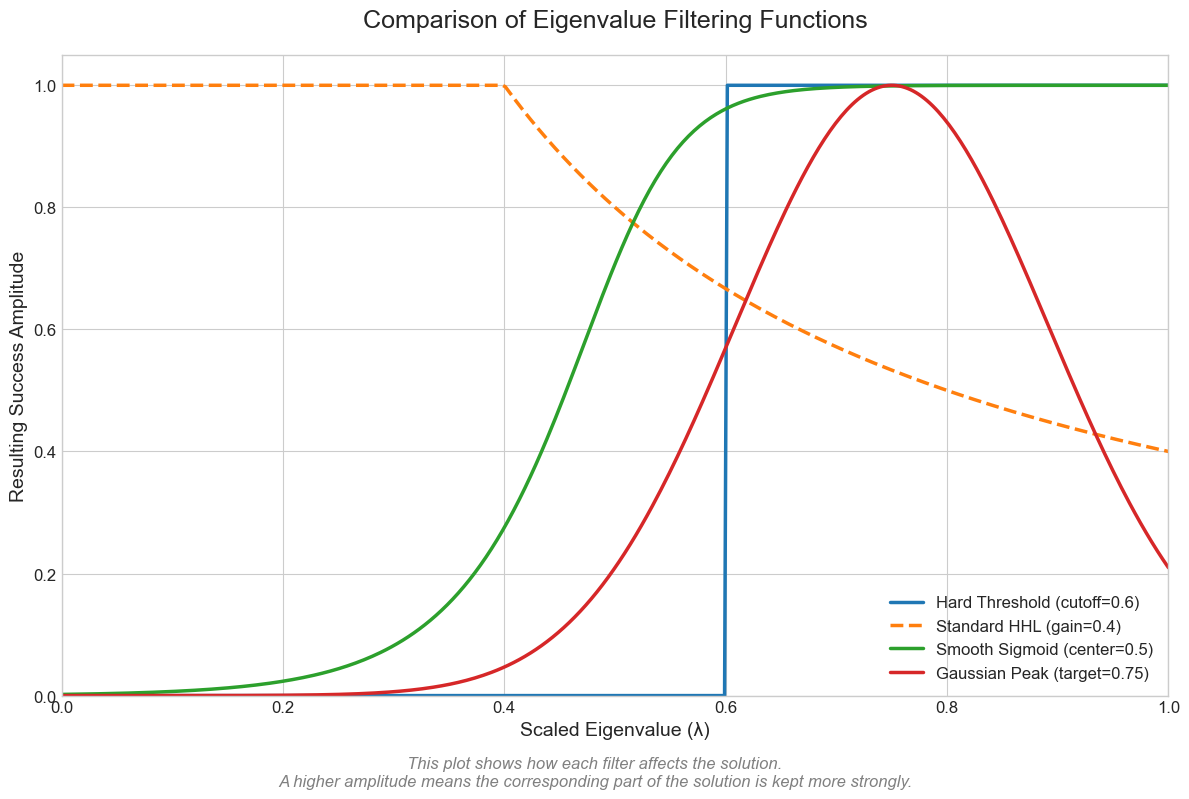

In [264]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Define the Parameters for Each Filter ---
# --- Play with these values to see how the curves change! ---

# 1. Hard Threshold Filter
HARD_THRESHOLD = 0.6

# 2. Standard HHL Filter (1/lambda)
# This gain constant is needed to keep the amplitude <= 1
HHL_GAIN = 0.4

# 3. Smooth Sigmoid Filter
SIGMOID_CENTER = 0.5  # The center of the transition
SIGMOID_STEEPNESS = 25  # A larger value makes the transition sharper

# 4. Gaussian Peak Filter
GAUSSIAN_TARGET = 0.75 # The eigenvalue we want to isolate
GAUSSIAN_SIGMA = 0.1   # A smaller sigma makes the peak narrower


# --- Step 2: Define the Filtering Functions ---
# Each function calculates the "success amplitude" for a given eigenvalue `lam`.
# The success amplitude is the value sin(angle/2) from our HHL rotation.

def hard_threshold_filter(lam, threshold):
    """Returns 1.0 if lam is above the threshold, 0.0 otherwise."""
    return 1.0 if lam >= threshold else 0.0

def standard_hhl_filter(lam, gain):
    """
    Returns an amplitude proportional to 1/lam.
    This amplifies smaller eigenvalues.
    """
    if lam < 1e-9: # Avoid division by zero
        return 1.0
    # The amplitude is clipped to be at most 1.0
    return np.clip(gain / lam, 0, 1.0)

def sigmoid_filter(lam, center, steepness):
    """
    Returns a smooth transition from 0 to 1 around the center.
    The probability is the sigmoid, the amplitude is its square root.
    """
    prob = 1 / (1 + np.exp(-steepness * (lam - center)))
    return np.sqrt(prob)

def gaussian_filter(lam, target, sigma):
    """
    Returns a bell curve centered on the target eigenvalue.
    The probability is the Gaussian, the amplitude is its square root.
    """
    prob = np.exp(-((lam - target)**2) / (2 * sigma**2))
    return np.sqrt(prob)


# --- Step 3: Generate Data and Plot ---

# Create a range of possible scaled eigenvalues from 0 to 1
lam_values = np.linspace(0, 1, 400)

# Calculate the success amplitude for each filter over the range of eigenvalues
amp_hard = [hard_threshold_filter(l, HARD_THRESHOLD) for l in lam_values]
amp_hhl = [standard_hhl_filter(l, HHL_GAIN) for l in lam_values]
amp_sigmoid = [sigmoid_filter(l, SIGMOID_CENTER, SIGMOID_STEEPNESS) for l in lam_values]
amp_gaussian = [gaussian_filter(l, GAUSSIAN_TARGET, GAUSSIAN_SIGMA) for l in lam_values]

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(lam_values, amp_hard, label=f'Hard Threshold (cutoff={HARD_THRESHOLD})', lw=2.5)
ax.plot(lam_values, amp_hhl, '--', label=f'Standard HHL (gain={HHL_GAIN})', lw=2.5)
ax.plot(lam_values, amp_sigmoid, label=f'Smooth Sigmoid (center={SIGMOID_CENTER})', lw=2.5)
ax.plot(lam_values, amp_gaussian, label=f'Gaussian Peak (target={GAUSSIAN_TARGET})', lw=2.5)

# Formatting the plot
ax.set_title('Comparison of Eigenvalue Filtering Functions', fontsize=18, pad=20)
ax.set_xlabel('Scaled Eigenvalue (λ)', fontsize=14)
ax.set_ylabel('Resulting Success Amplitude', fontsize=14)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add text explaining the plot
info_text = (
    "This plot shows how each filter affects the solution.\n"
    "A higher amplitude means the corresponding part of the solution is kept more strongly."
)
fig.text(0.5, 0.01, info_text, ha='center', fontsize=12, style='italic', color='gray')


plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

--- INSIDE analyze_solution_spectrum ---
Initial shape of matrix_A: (8, 8)
Initial shape of vector_b: (8,)
Shape of vector_b after flattening: (8,)
-------------------------------------

Eingenvalues: [4. 2. 4. 2. 3. 3. 3. 3.]
Eingenvectors: [[ 0.70710678  0.70710678  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.
   0.          0.        ]
 [ 0.          0.         -0.70710678  0.70710678  0.          0.
   0.          0.        ]
 [-0.70710678  0.70710678  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.        ]
 [ 0.          0.          0.70710678  0.70710678  0.          0.
   0.          0.        ]]
--- Loop iter

/Users/xenofonchiotopoulos/Desktop/PHD_STUFF/Toy_model/LHCb_VeLo_Toy_Model/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


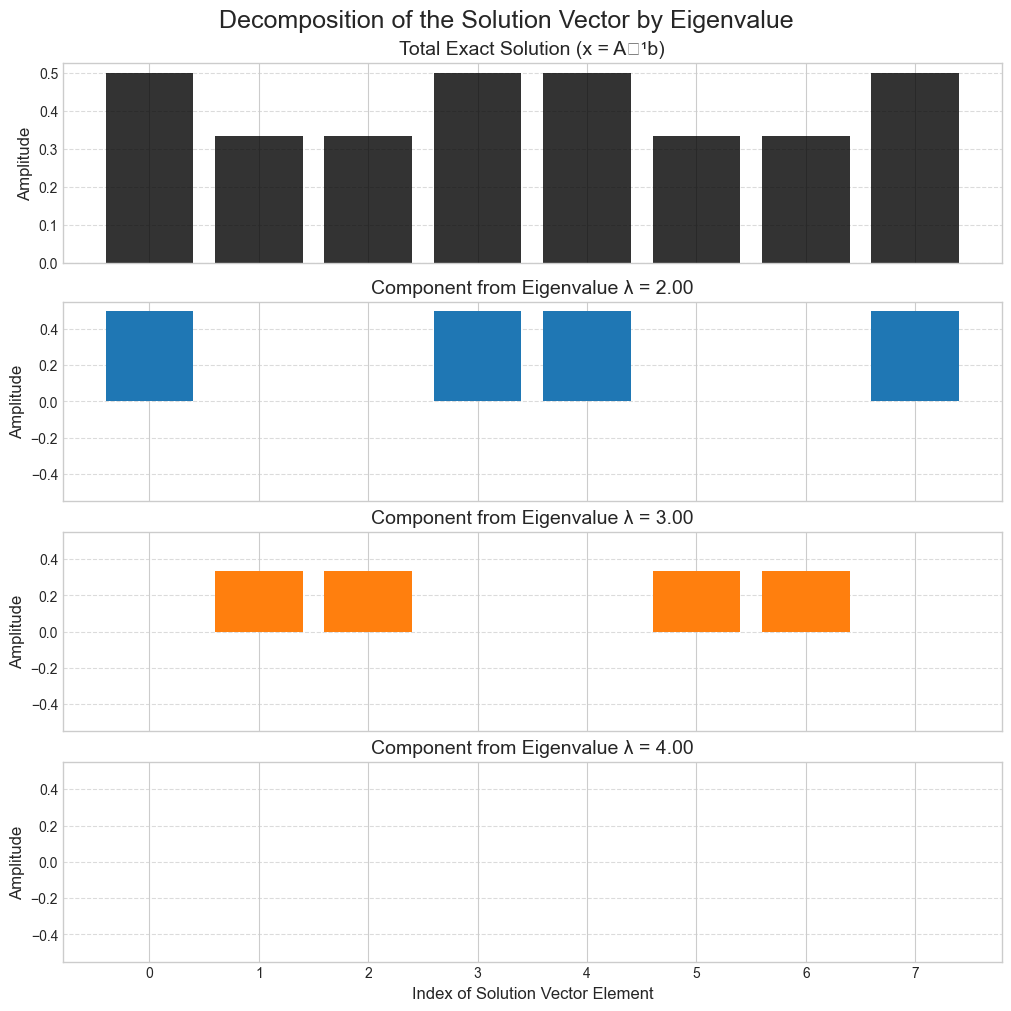

In [265]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_solution_spectrum(matrix_A, vector_b):
    """
    Classically computes the exact solution to Ax=b and decomposes it
    into components based on the eigenvalues of A, with added debugging prints.
    """
    print("--- INSIDE analyze_solution_spectrum ---")
    print(f"Initial shape of matrix_A: {matrix_A.shape}")
    print(f"Initial shape of vector_b: {vector_b.shape}")

    # --- ROBUSTNESS FIX ---
    # Ensure the input vector is a 1D array ('flattened').
    vector_b = vector_b.flatten()
    print(f"Shape of vector_b after flattening: {vector_b.shape}")
    print("-------------------------------------\n")


    if matrix_A.shape[0] != matrix_A.shape[1]:
        raise ValueError("Matrix A must be square.")
    if matrix_A.shape[0] != len(vector_b):
        raise ValueError("Matrix and vector dimensions must match.")

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eig(matrix_A)
    print('Eingenvalues:', eig_vals)
    print('Eingenvectors:', eig_vecs)
    # Change of basis
    betas = np.linalg.inv(eig_vecs) @ vector_b

    # Prepare for component calculation
    unique_eigenvalues = np.unique(np.round(eig_vals, 5))
    component_solutions = {lam: np.zeros_like(vector_b, dtype=complex) for lam in unique_eigenvalues}

    # Calculate individual solution components
    for i in range(len(eig_vals)):
        lam = eig_vals[i]
        beta = betas[i]
        u_vec = eig_vecs[:, i]
        
        key = unique_eigenvalues[np.argmin(np.abs(unique_eigenvalues - lam))]
        
        if abs(lam) > 1e-9:
            component = (beta / lam) * u_vec
            
            # --- DEBUGGING PRINT STATEMENTS ---
            print(f"--- Loop iteration i={i} ---")
            print(f"Eigenvalue (key): {key:.2f}")
            print(f"Shape of component_solutions[key] (left side of +=): {component_solutions[key].shape}")
            print(f"Shape of component (right side of +=):            {component.shape}")
            
            # This is the line that causes the error
            component_solutions[key] += component
            
            print("...addition successful.\n")


    # Calculate the total solution for comparison
    total_exact_solution = np.linalg.solve(matrix_A, vector_b)

    # Plotting
    num_plots = len(unique_eigenvalues) + 1
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, num_plots * 2.5), sharex=True, constrained_layout=True)
    fig.suptitle('Decomposition of the Solution Vector by Eigenvalue', fontsize=18)

    axes[0].bar(range(len(total_exact_solution)), total_exact_solution.real, color='black', alpha=0.8)
    axes[0].set_title('Total Exact Solution (x = A⁻¹b)', fontsize=14)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    plot_idx = 1
    max_comp_amp = max([np.max(np.abs(comp.real)) for comp in component_solutions.values()] + [0])
    if max_comp_amp == 0: max_comp_amp = 1.0

    for lam, component_vec in sorted(component_solutions.items()):
        ax = axes[plot_idx]
        ax.bar(range(len(component_vec)), component_vec.real, color=f'C{plot_idx-1}')
        ax.set_title(f'Component from Eigenvalue λ = {lam:.2f}', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim(-max_comp_amp * 1.1, max_comp_amp * 1.1)
        plot_idx += 1

    axes[-1].set_xlabel('Index of Solution Vector Element', fontsize=12)
    plt.show()

# --- Main execution block ---
'''matrix_A = np.array([
	[3., 0., 0., 0., -1, 0., 0., 0.],
	[0., 3., 0., 0., 0., 0., 0., 0.],
	[0., 0., 3., 0., 0., 0., 0., 0.],
	[0., 0., 0., 3., 0., 0., 0., -1],
	[-1, 0., 0., 0., 3., 0., 0., 0.],
	[0., 0., 0., 0., 0., 3., 0., 0.],
	[0., 0., 0., 0., 0., 0., 3., 0.],
	[0., 0., 0., -1, 0., 0., 0., 3.]
])
vector_b = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])'''
    
analyze_solution_spectrum(np.array(matrix_A), np.array(vector_b))

# HHL classical benchmarking

Each plots has three points in x-axis. For the y-axis plot the average number over 10 events and take the RMS as the error bar.
Make the whole thing into a script so that you can re-use it later when we want to change a few things.

1. Track Efficiency ("y-axis") vs multiple scattering parameter ("x-axis").
Include each of the three resolution settings, plot the result with rms error bar over 10 events. Keep the inefficiency parameter at 0%. So in total 9 points.

2. Track Ghostrate ("y-axis") vs multiple scattering parameter ("x-axis").
Include each of the three resolution settings, plot the result with rms error bar over 10 events. Keep the inefficiency parameter at 0%. Again, in total 9 points.

3. Hit Efficiency ("y-axis") vs inefficient hit parameter ("x-axis"). 
Keep the multiple scattering at setting 0.0002 and plot the values for each of the hit resolution values. Again averages over 10 events with rms error bar. In total 9 points.

3. Hit Purity ("y-axis") vs inefficient hit parameter ("x-axis"). 
Keep the multiple scattering at setting 0.0002 and plot the values for each of the hit resolution values. Again averages over 10 events with rms error bar. In total 9 points.

Specific request: 
Please pay attention to make each axis correct and use correct labels. Set the minimum and maximum of axes so that they make sense and you can inspect the results.
Please do *not* go for speed, but cross check the contents to see if they make sense to you. 


In [2]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian
import qiskit
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
from scipy.linalg import solve
from hhl_algorithm import HHLAlgorithm as hhl
from hhl_algorithm_1bit import HHLAlgorithm as hhl_1
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
import itertools as it
import json
import pandas as pd

In [ ]:
"""
Parameter sweep over detector / reconstruction nuisance parameters.

For each combination of:
    - measurement (hit) resolution (measurement_errors)
    - multiple scattering (collision_noises)
    - ghost (fake) track rate (ghost_rates)
    - hit drop (inefficiency) rate (drop_rates)

the workflow is:
    1. Build a simple planar detector geometry.
    2. Generate events with a fixed number of particles.
    3. Produce true tracks and then inject noise (ghost & dropped hits).
    4. Build and solve a (classical) SimpleHamiltonian to select hits.
    5. Reconstruct tracks from the discretized solution.
    6. Validate reconstructed tracks against truth and collect metrics.
    7. Persist all results into a JSON file (results.json).

Outputs:
    - 'results' dict (indexed by sweep counter) with input params + metrics.
    - results.json written to working directory.

Notes:
    - 'epsilon_min' is computed but (currently) not used; the Hamiltonian
        epsilon is hard‑coded to (1 - cos(0.0015)). If adaptive epsilon is
        desired, replace ham = SimpleHamiltonian(... epsilon=epsilon_min, ...)
    - The original line computing epsilon_min used np.max with multiple
        positional arguments (not valid). It is documented/fixed here.
"""

# --- Constants ---
dz = 33  # mm layer spacing
layers = 5
n_particles = [10, 10, 10, 10]              # list so generator can vary per event if needed
events = len(n_particles)       # number of events
n = np.sum(n_particles)         # total number of particles across events

# Detector configuration
module_id = list(range(1, layers + 1))
lx = [80] * layers
ly = [80] * layers
zs = [dz * l for l in range(1, layers + 1)]

# HIT RESOLUTION (sigma on measurement) (sigma)
measurement_errors = [0, 2e-3, 4e-3, 6e-4]

# MULTIPLE SCATTERING (angular noise proxy)
collision_noises = [0, 2e-4, 4e-4, 6e-4, 8e-4, 1e-3]

# Noise and error parameters
ghost_rates = [1e-2, 2e-2, 4e-2]
drop_rates = [0.0, 1e-1, 2e-2, 4e-2]

# Minimum epsilon (geometric small-angle threshold)
arbitrary_minimum_value_of_epsilon = 1 - np.cos(0.0015)
scale_factor = 5


# Results container
results = {}

# --- Main parameter sweep ---
print("Starting parameter sweep...")

i = 0

events_store = {}

for mes_error, coll_noise, ghost, drop in it.product(
                measurement_errors, collision_noises, ghost_rates, drop_rates):

        # Scale transformations for thresholds
        theta_s = scale_factor*coll_noise
        theta_r = np.arctan(scale_factor*mes_error/dz)
        theta_m = 0.0015

        epsilon_s = 1 - np.cos(theta_s)
        epsilon_r = 1 - np.cos(theta_r)
        epsilon_m = 1 - np.cos(theta_m)

        epsilon_win = max(epsilon_s, epsilon_r, epsilon_m)

        print(f'THETAS : {theta_s}, {theta_r}, {theta_m} -> {epsilon_win}')

        print(f'EPSILONS: {epsilon_s}, {epsilon_r}, {epsilon_m} -> {epsilon_win}')

        print(f"\nRunning simulation with:")
        print(f"  Measurement error = {mes_error}")
        print(f"  Collision noise   = {coll_noise}")
        print(f"  Ghost rate        = {ghost}")
        print(f"  Drop rate         = {drop}")

        # --- Detector setup ---
        Detector = state_event_model.PlaneGeometry(
                module_id=module_id, lx=lx, ly=ly, z=zs
        )

        # --- State event generator setup ---
        state_event_gen = StateEventGenerator(
                Detector,
                events=events,
                n_particles=n_particles,
                measurement_error=mes_error,
                collision_noise=coll_noise
        )

        # Random primary vertices (unit box extents in x,y,z)
        state_event_gen.generate_random_primary_vertices({'x': 1, 'y': 1, 'z': 1})

        # Particle species definition (all identical MIPs here)
        event_particles = [[{'type': 'MIP', 'mass': 0.511, 'q': 1} for _ in range(n)] for _ in range(events)]

        # Generate truth particles and full event (hits + associations)
        state_event_gen.generate_particles(event_particles)
        event_tracks = state_event_gen.generate_complete_events()

        # --- Inject noise into events (ghost hits/tracks & dropped hits) ---
        false_tracks = state_event_gen.make_noisy_event(drop_rate=drop, ghost_rate=ghost)

        # --- Hamiltonian construction & solve ---
        # If adaptive epsilon desired, replace (1-np.cos(0.0015)) with epsilon_min
        ham = SimpleHamiltonian(epsilon=epsilon_win, gamma=2.0, delta=1.0)
        print(f"  -> Hamiltonian parameters: epsilon={ham.epsilon}, gamma={ham.gamma}, delta={ham.delta}")
        ham.construct_hamiltonian(event=event_tracks, convolution=True)

        print("Solving classical Hamiltonian...")
        classical_solution = ham.solve_classicaly()

        # Threshold solution to pick active hits (0/1 mask)
        discretized_solution = (classical_solution > 0.45).astype(int)

        # --- Track reconstruction and validation ---
        rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
        validator = evl(false_tracks, rec_tracks)
        metrics = validator.compute_metrics()
        # print(f"  -> Metrics: {metrics}")

        # Store result snapshot
        results[i] = {
                'Hit_res': mes_error,
                'Multi_scatter': coll_noise,
                'noise_rate': ghost,
                'efficency_err': drop,
                'metrics': metrics,
                'epsilon': ham.epsilon,
                'phi_range' : state_event_gen.phi_max,
                'theta_range' : state_event_gen.theta_max,
                'primary_verticies' : state_event_gen.primary_vertices,
                'event_count' : state_event_gen.events_num
        }

        p = {
                'Hit_res': mes_error,
                'Multi_scatter': coll_noise,
                'noise_rate': ghost,
                'epsilon': ham.epsilon,
                'phi_range' : state_event_gen.phi_max,
                'theta_range' : state_event_gen.theta_max,
                'primary_verticies' : state_event_gen.primary_vertices,
                'event_count' : state_event_gen.events_num
        }
        i += 1

        #plot event
        # event_tracks.plot_segments()

        # event_tracks.save_plot_segments(f"plots/event_{i}.png",p)

print("\nParameter sweep completed. Saving results...")

### OLD METRICS

old_res = pd.read_json("results.json").transpose()

# Convert dictionary column to separate columns with suffix "_metrics"
old_metrics_df = old_res['metrics'].apply(pd.Series).add_suffix('_metrics')

old_res = pd.concat([old_res, old_metrics_df], axis=1, join='inner').drop(columns=['metrics'])


for item in results[0].values():
    print(f"  - {item}, {type(item)}")

# --- Save results to JSON file ---
with open(f"results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Results saved to 'results.json'.")


import pandas as pd 
res = pd.read_json("results.json").transpose()

# Convert dictionary column to separate columns with suffix "_metrics"
metrics_df = res['metrics'].apply(pd.Series).add_suffix('_metrics')

res = pd.concat([res, metrics_df], axis=1, join='inner')

res = pd.concat([old_res, res], axis=0, ignore_index=True)

res.to_csv("metrics.csv", index=False)

Starting parameter sweep...
THETAS : 0, 0.0, 0.0015 -> 1.1249997891038532e-06
EPSILONS: 0.0, 0.0, 1.1249997891038532e-06 -> 1.1249997891038532e-06

Running simulation with:
  Measurement error = 0
  Collision noise   = 0
  Ghost rate        = 0.01
  Drop rate         = 0.0
  -> Hamiltonian parameters: epsilon=1.1249997891038532e-06, gamma=2.0, delta=1.0
Solving classical Hamiltonian...
THETAS : 0, 0.0, 0.0015 -> 1.1249997891038532e-06
EPSILONS: 0.0, 0.0, 1.1249997891038532e-06 -> 1.1249997891038532e-06

Running simulation with:
  Measurement error = 0
  Collision noise   = 0
  Ghost rate        = 0.01
  Drop rate         = 0.1
  -> Hamiltonian parameters: epsilon=1.1249997891038532e-06, gamma=2.0, delta=1.0
Solving classical Hamiltonian...
THETAS : 0, 0.0, 0.0015 -> 1.1249997891038532e-06
EPSILONS: 0.0, 0.0, 1.1249997891038532e-06 -> 1.1249997891038532e-06

Running simulation with:
  Measurement error = 0
  Collision noise   = 0
  Ghost rate        = 0.01
  Drop rate         = 0.02
  -

In [18]:
import pandas as pd 
res = pd.read_json("results.json").transpose()

# Convert dictionary column to separate columns with suffix "_metrics"
metrics_df = res['metrics'].apply(pd.Series).add_suffix('_metrics')

res = pd.concat([res, metrics_df], axis=1, join='inner').drop(columns=['metrics'])

res.to_csv("metrics.csv", index=False)

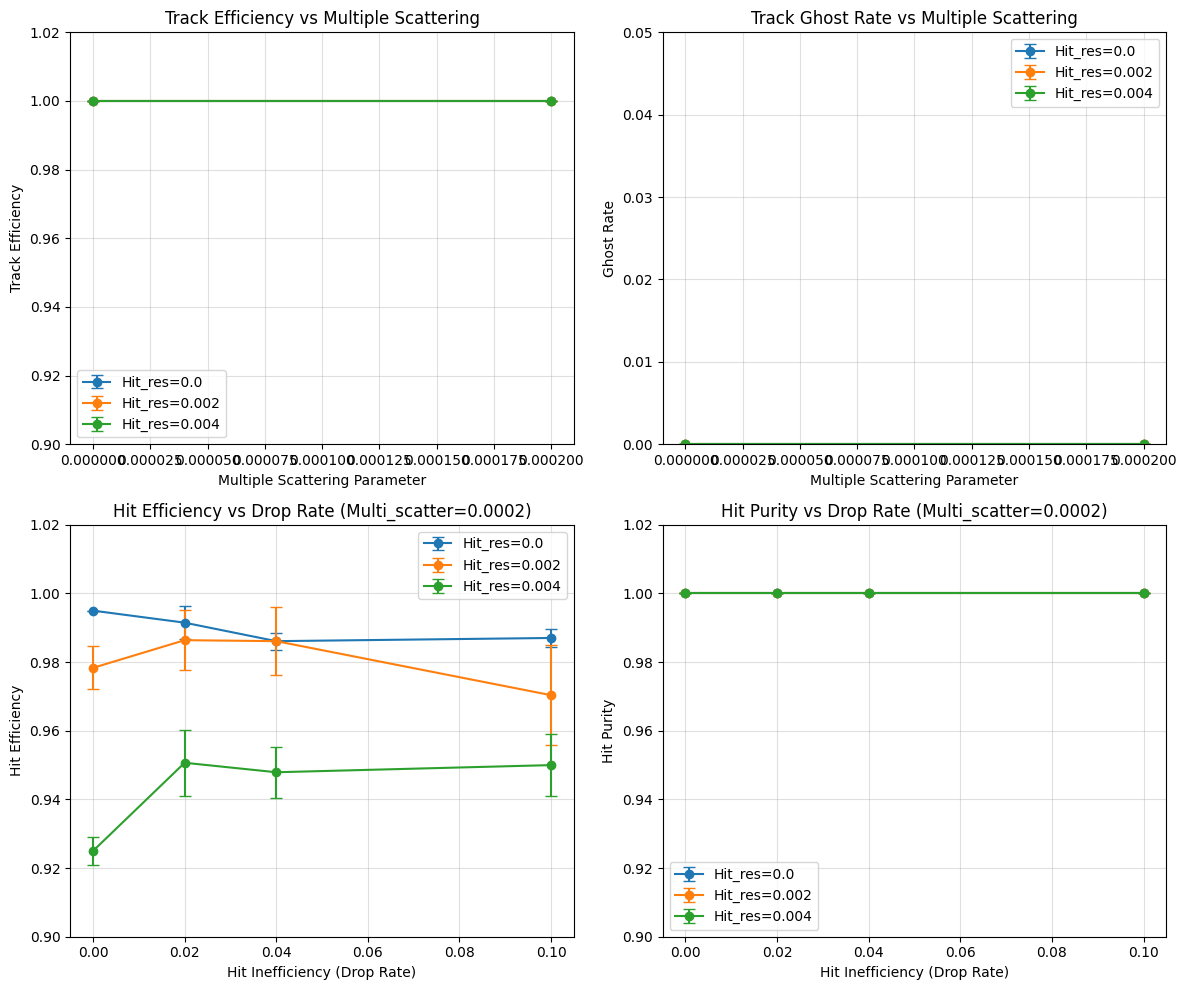

{'track_eff':    Hit_res  Multi_scatter  mean  rms  n
 0    0.000         0.0000   1.0  0.0  3
 1    0.000         0.0002   1.0  0.0  3
 2    0.002         0.0000   1.0  0.0  3
 3    0.002         0.0002   1.0  0.0  3
 4    0.004         0.0000   1.0  0.0  3
 5    0.004         0.0002   1.0  0.0  3,
 'ghost_rate':    Hit_res  Multi_scatter  mean  rms  n
 0    0.000         0.0000   0.0  0.0  3
 1    0.000         0.0002   0.0  0.0  3
 2    0.002         0.0000   0.0  0.0  3
 3    0.002         0.0002   0.0  0.0  3
 4    0.004         0.0000   0.0  0.0  3
 5    0.004         0.0002   0.0  0.0  3,
 'hit_eff':     Hit_res  efficency_err      mean       rms  n
 0     0.000           0.00  0.995000  0.000000  3
 1     0.000           0.02  0.991497  0.004810  3
 2     0.000           0.04  0.986111  0.002455  3
 3     0.000           0.10  0.987037  0.002619  3
 4     0.002           0.00  0.978333  0.006236  3
 5     0.002           0.02  0.986395  0.008672  3
 6     0.002           0.04  

In [7]:
def rms(series):
    """Root-mean-square deviation (population)."""
    arr = series.to_numpy(dtype=float)
    if arr.size == 0:
        return np.nan
    m = arr.mean()
    return np.sqrt(np.mean((arr - m) ** 2))

def prepare_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def aggregate_metric(df, group_cols, value_col):
    g = df.groupby(group_cols, dropna=False)[value_col]
    agg = g.agg(mean='mean',
                rms=lambda x: rms(x),
                n='count')
    return agg.reset_index()

def plot_with_errorbars(ax, agg_df, x_col, y_mean, y_err, label_col,
                        xlabel, ylabel, title, y_min=None, y_max=None, x_min=None, x_max=None):
    for label, sub in agg_df.groupby(label_col):
        sub_sorted = sub.sort_values(x_col)
        ax.errorbar(sub_sorted[x_col], sub_sorted[y_mean],
                    yerr=sub_sorted[y_err],
                    marker='o', capsize=4, lw=1.5, label=f"{label_col}={label}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if y_min is not None or y_max is not None:
        ax.set_ylim(y_min, y_max)
    if x_min is not None or x_max is not None:
        ax.set_xlim(x_min, x_max)
    ax.grid(alpha=0.4)
    ax.legend()

def make_performance_plots(res_df, save_prefix="perf"):
    # Copy to avoid modifying original
    df = res_df.copy()

    # Ensure required numeric columns
    numeric_cols = ['Hit_res', 'Multi_scatter', 'efficency_err',
                    'reconstruction_efficiency_metrics', 'ghost_rate_metrics',
                    'hit_efficiency_metrics', 'purity_metrics']
    df = prepare_numeric(df, numeric_cols)

    # Filter inefficiency=0% for first two plots
    base = df[df['efficency_err'] == 0]

    # 1. Track Efficiency vs Multiple Scattering (lines = Hit_res)
    agg_te = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'reconstruction_efficiency_metrics')

    # 2. Track Ghostrate vs Multiple Scattering (lines = Hit_res)
    agg_gr = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'ghost_rate_metrics')

    # 3. Hit Efficiency vs Inefficient Hit Parameter (drop) at Multi_scatter = 0.0002
    target_ms = 0.0002
    subset_ms = df[df['Multi_scatter'] == target_ms]
    agg_he = aggregate_metric(subset_ms, ['Hit_res', 'efficency_err'],
                              'hit_efficiency_metrics')

    # 4. Hit Purity vs Inefficient Hit Parameter (drop) at Multi_scatter = 0.0002
    agg_hp = aggregate_metric(subset_ms, ['Hit_res', 'efficency_err'],
                              'purity_metrics')

    # Determine sensible axis limits
    eff_cols = [
        'reconstruction_efficiency_metrics',
        'hit_efficiency_metrics',
        'purity_metrics'
    ]
    eff_max = min(1.0, max([df[c].max() for c in eff_cols if c in df])) if len(df) else 1.0
    eff_min = max(0.0, min([df[c].min() for c in eff_cols if c in df])) if len(df) else 0.0
    y_eff_lo = max(0.0, eff_min - 0.02)
    y_eff_hi = min(1.05, eff_max + 0.02)

    ghost_max = base['ghost_rate_metrics'].max() if len(base) else 0.05
    y_ghost_hi = ghost_max * 1.25 if ghost_max > 0 else 0.05

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    plot_with_errorbars(
        axes[0], agg_te, x_col='Multi_scatter',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        xlabel='Multiple Scattering Parameter',
        ylabel='Track Efficiency',
        title='Track Efficiency vs Multiple Scattering',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    plot_with_errorbars(
        axes[1], agg_gr, x_col='Multi_scatter',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        xlabel='Multiple Scattering Parameter',
        ylabel='Ghost Rate',
        title='Track Ghost Rate vs Multiple Scattering',
        y_min=0.0, y_max=y_ghost_hi
    )

    plot_with_errorbars(
        axes[2], agg_he, x_col='efficency_err',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        xlabel='Hit Inefficiency (Drop Rate)',
        ylabel='Hit Efficiency',
        title=f'Hit Efficiency vs Drop Rate (Multi_scatter={target_ms})',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    plot_with_errorbars(
        axes[3], agg_hp, x_col='efficency_err',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        xlabel='Hit Inefficiency (Drop Rate)',
        ylabel='Hit Purity',
        title=f'Hit Purity vs Drop Rate (Multi_scatter={target_ms})',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    plt.tight_layout()
    plt.show()

    # Optionally save aggregated data
    agg_te.to_csv(f"{save_prefix}_track_eff_vs_ms.csv", index=False)
    agg_gr.to_csv(f"{save_prefix}_ghost_vs_ms.csv", index=False)
    agg_he.to_csv(f"{save_prefix}_hit_eff_vs_drop.csv", index=False)
    agg_hp.to_csv(f"{save_prefix}_hit_purity_vs_drop.csv", index=False)

    return {
        'track_eff': agg_te,
        'ghost_rate': agg_gr,
        'hit_eff': agg_he,
        'hit_purity': agg_hp
    }

# Execute with current 'res' dataframe
aggregates = make_performance_plots(res)
aggregates

In [ ]:
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots

import plotly.graph_objects as go

def rms(series):
    arr = series.to_numpy(dtype=float)
    if arr.size == 0:
        return np.nan
    m = arr.mean()
    return np.sqrt(np.mean((arr - m) ** 2))

def prepare_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def aggregate_metric(df, group_cols, value_col):
    g = df.groupby(group_cols, dropna=False)[value_col]
    agg = g.agg(mean='mean',
                rms=lambda x: rms(x),
                n='count')
    return agg.reset_index()

def add_errorbar_traces(fig, agg_df, x_col, y_mean, y_err, label_col,
                        row, col, xlabel, ylabel, title,
                        y_min=None, y_max=None, x_min=None, x_max=None):
    # Sort within each label for line continuity
    for label, sub in agg_df.groupby(label_col):
        sub = sub.sort_values(x_col)
        fig.add_trace(
            go.Scatter(
                x=sub[x_col],
                y=sub[y_mean],
                mode='lines+markers',
                name=f"{label_col}={label}",
                error_y=dict(
                    type='data',
                    array=sub[y_err],
                    visible=True,
                    thickness=1,
                    width=3
                )
            ),
            row=row, col=col
        )
    fig.update_xaxes(title_text=xlabel, row=row, col=col,
                     range=[x_min, x_max] if (x_min is not None or x_max is not None) else None)
    fig.update_yaxes(title_text=ylabel, row=row, col=col,
                     range=[y_min, y_max] if (y_min is not None or y_max is not None) else None)
    fig.layout.annotations[(row-1)*fig._cols + (col-1)].text = title  # set subplot title

def make_performance_plots_plotly(res_df, save_prefix="perf"):
    df = res_df.copy()
    numeric_cols = ['Hit_res', 'Multi_scatter', 'efficency_err',
                    'reconstruction_efficiency_metrics', 'ghost_rate_metrics',
                    'hit_efficiency_metrics', 'purity_metrics']
    df = prepare_numeric(df, numeric_cols)

    base = df[df['efficency_err'] == 0]

    agg_te = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'reconstruction_efficiency_metrics')
    agg_gr = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'ghost_rate_metrics')

    target_ms = 0.0002
    subset_ms = df[df['Multi_scatter'] == target_ms]
    agg_he = aggregate_metric(subset_ms, ['Hit_res', 'efficency_err'],
                              'hit_efficiency_metrics')
    agg_hp = aggregate_metric(subset_ms, ['Hit_res', 'efficency_err'],
                              'purity_metrics')

    eff_cols = [
        'reconstruction_efficiency_metrics',
        'hit_efficiency_metrics',
        'purity_metrics'
    ]
    eff_max = min(1.0, max([df[c].max() for c in eff_cols if c in df])) if len(df) else 1.0
    eff_min = max(0.0, min([df[c].min() for c in eff_cols if c in df])) if len(df) else 0.0
    y_eff_lo = max(0.0, eff_min - 0.02)
    y_eff_hi = min(1.05, eff_max + 0.02)

    ghost_max = base['ghost_rate_metrics'].max() if len(base) else 0.05
    y_ghost_hi = ghost_max * 1.25 if ghost_max > 0 else 0.05

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Track Efficiency vs Multiple Scattering',
            'Track Ghost Rate vs Multiple Scattering',
            f'Hit Efficiency vs Drop Rate (Multi_scatter={target_ms})',
            f'Hit Purity vs Drop Rate (Multi_scatter={target_ms})'
        )
    )

    add_errorbar_traces(
        fig, agg_te, x_col='Multi_scatter',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        row=1, col=1,
        xlabel='Multiple Scattering Parameter',
        ylabel='Track Efficiency',
        title='Track Efficiency vs Multiple Scattering',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    add_errorbar_traces(
        fig, agg_gr, x_col='Multi_scatter',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        row=1, col=2,
        xlabel='Multiple Scattering Parameter',
        ylabel='Ghost Rate',
        title='Track Ghost Rate vs Multiple Scattering',
        y_min=0.0, y_max=y_ghost_hi
    )

    add_errorbar_traces(
        fig, agg_he, x_col='efficency_err',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        row=2, col=1,
        xlabel='Hit Inefficiency (Drop Rate)',
        ylabel='Hit Efficiency',
        title=f'Hit Efficiency vs Drop Rate (Multi_scatter={target_ms})',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    add_errorbar_traces(
        fig, agg_hp, x_col='efficency_err',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        row=2, col=2,
        xlabel='Hit Inefficiency (Drop Rate)',
        ylabel='Hit Purity',
        title=f'Hit Purity vs Drop Rate (Multi_scatter={target_ms})',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    fig.update_layout(
        height=800,
        width=1100,
        legend_title_text='Hit_res',
        hovermode='x unified',
        title='Performance Metrics'
    )

    fig.show()

    # Optionally save aggregated data
    agg_te.to_csv(f"{save_prefix}_track_eff_vs_ms.csv", index=False)
    agg_gr.to_csv(f"{save_prefix}_ghost_vs_ms.csv", index=False)
    agg_he.to_csv(f"{save_prefix}_hit_eff_vs_drop.csv", index=False)
    agg_hp.to_csv(f"{save_prefix}_hit_purity_vs_drop.csv", index=False)

    return {
        'track_eff': agg_te,
        'ghost_rate': agg_gr,
        'hit_eff': agg_he,
        'hit_purity': agg_hp,
        'figure': fig
    }

aggregates = make_performance_plots_plotly(res)
aggregates

Hit_res Multi_scatter noise_rate efficency_err   epsilon phi_range  \
0       0             0       0.01           0.0  0.000001       0.2   
1       0        0.0002       0.01           0.0  0.000001       0.2   
2       0        0.0004       0.01           0.0  0.000002       0.2   
3   0.002             0       0.01           0.0  0.000001       0.2   
4   0.002        0.0002       0.01           0.0  0.000001       0.2   
5   0.002        0.0004       0.01           0.0  0.000002       0.2   
6   0.004             0       0.01           0.0  0.000001       0.2   
7   0.004        0.0002       0.01           0.0  0.000001       0.2   
8   0.004        0.0004       0.01           0.0  0.000002       0.2   

  theta_range                                  primary_verticies event_count  \
0         0.2  [[0, 0, -0.317832203504378], [0, 0, -0.0902053...           4   
1         0.2  [[0, 0, 1.7831281023698562], [0, 0, -0.1934005...           4   
2         0.2  [[0, 0, -0.932348320345562], [0, 0, 0.63550654...           4   
3         0.2  [[0, 0, 1.3727193745491681], [0, 0, 1.02264696...           4   
4         0.2  [[0, 0, -1.089483572321537], [0, 0, -1.1748610...           4   
5         0.2  [[0, 0, -0.552393142420136], [0, 0, -0.3310915...           4   
6         0.2  [[0, 0, -0.7166754668566181], [0, 0, -0.178601...           4   
7         0.2  [[0, 0, 1.059292618532701], [0, 0, 0.946186738...           4   
8         0.2  [[0, 0, 0.014850039798251], [0, 0, 1.625207622...           4   

   ghost_rate_metrics  clone_fraction_metrics  \
0            0.006329                     0.0   
1            0.006289                     0.0   
2            0.000000                     0.0   
3            0.006329                     0.0   
4            0.012821                     0.0   
5            0.012903                     0.0   
6            0.006289                     0.0   
7            0.019108                     0.0   
8            0.000000                     0.0   

   reconstruction_efficiency_metrics  hit_efficiency_metrics  purity_metrics  \
0                            0.98125                 0.98125        1.000000   
1                            0.98750                 0.98125        1.000000   
2                            1.00000                 0.79125        1.000000   
3                            0.98125                 0.98125        1.000000   
4                            0.96250                 0.95125        1.000000   
5                            0.95625                 0.75875        1.000000   
6                            0.98750                 0.98500        0.998945   
7                            0.96250                 0.91125        1.000000   
8                            0.98125                 0.75250        1.000000   

   total_rec_tracks_metrics  total_truth_tracks_metrics ghost_tracks_metrics  \
0                       158                         160                 [13]   
1                       159                         160                 [11]   
2                       160                         160                   []   
3                       158                         160                 [10]   
4                       156                         160             [23, 66]   
5                       155                         160            [12, 114]   
6                       159                         160                 [46]   
7                       157                         160         [38, 90, 95]   
8                       157                         160                   []   

   clones_count_metrics  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

In [8]:
metrics_df.to_csv("metrics.csv", index=False)

In [3]:
# --- Constants ---
dz = 33  # mm layer spacing
layers = 5
n_particles = [10]              # list so generator can vary per event if needed
events = len(n_particles)       # number of events
n = np.sum(n_particles)         # total number of particles across events

# Detector configuration
module_id = list(range(1, layers + 1))
lx = [80] * layers
ly = [80] * layers
zs = [dz * l for l in range(1, layers + 1)]

# HIT RESOLUTION (sigma on measurement) (sigma)
measurement_errors = [4e-3]

# MULTIPLE SCATTERING (angular noise proxy)
collision_noises = [4e-4]

# Noise and error parameters
ghost_rates = [1e-2]
drop_rates = [0.02]

# Minimum epsilon (geometric small-angle threshold)
arbitrary_minimum_value_of_epsilon = 1 - np.cos(0.0015)
scale_factor = 5


# Results container
results = {}

# --- Main parameter sweep ---
print("Starting parameter sweep...")

i = 0

for mes_error, coll_noise, ghost, drop in it.product(
                measurement_errors, collision_noises, ghost_rates, drop_rates):

        # Scale transformations for thresholds
        theta_s = scale_factor*coll_noise
        theta_r = np.arctan(scale_factor*mes_error/dz)
        theta_m = 0.0015

        epsilon_s = 1 - np.cos(theta_s)
        epsilon_r = 1 - np.cos(theta_r)
        epsilon_m = 1 - np.cos(theta_m)

        epsilon_win = max(epsilon_s, epsilon_r, epsilon_m)

        print(f'THETAS : {theta_s}, {theta_r}, {theta_m} -> {epsilon_win}')

        print(f'EPSILONS: {epsilon_s}, {epsilon_r}, {epsilon_m} -> {epsilon_win}')

        print(f"\nRunning simulation with:")
        print(f"  Measurement error = {mes_error}")
        print(f"  Collision noise   = {coll_noise}")
        print(f"  Ghost rate        = {ghost}")
        print(f"  Drop rate         = {drop}")

        # --- Detector setup ---
        Detector = state_event_model.PlaneGeometry(
                module_id=module_id, lx=lx, ly=ly, z=zs
        )

        # --- State event generator setup ---
        state_event_gen = StateEventGenerator(
                Detector,
                events=events,
                n_particles=n_particles,
                measurement_error=mes_error,
                collision_noise=coll_noise
        )

        # Random primary vertices (unit box extents in x,y,z)
        state_event_gen.generate_random_primary_vertices({'x': 1, 'y': 1, 'z': 1})

        # Particle species definition (all identical MIPs here)
        event_particles = [[{'type': 'MIP', 'mass': 0.511, 'q': 1} for _ in range(n)] for _ in range(events)]

        # Generate truth particles and full event (hits + associations)
        state_event_gen.generate_particles(event_particles)
        event_tracks = state_event_gen.generate_complete_events()

        # --- Inject noise into events (ghost hits/tracks & dropped hits) ---
        false_tracks = state_event_gen.make_noisy_event(drop_rate=drop, ghost_rate=ghost)

        # --- Hamiltonian construction & solve ---
        # If adaptive epsilon desired, replace (1-np.cos(0.0015)) with epsilon_min
        ham = SimpleHamiltonian(epsilon=epsilon_win, gamma=2.0, delta=1.0)
        print(f"  -> Hamiltonian parameters: epsilon={ham.epsilon}, gamma={ham.gamma}, delta={ham.delta}")
        ham.construct_hamiltonian(event=event_tracks, convolution=True)

        print("Solving classical Hamiltonian...")
        classical_solution = ham.solve_classicaly()

        # Threshold solution to pick active hits (0/1 mask)
        discretized_solution = (classical_solution > 0.45).astype(int)

        # --- Track reconstruction and validation ---
        rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
        validator = evl(false_tracks, rec_tracks)
        metrics = validator.compute_metrics()
        print(f"  -> Metrics: {metrics}")

        # Store result snapshot
        results[i] = {
                'Hit_res': mes_error,
                'Multi_scatter': coll_noise,
                'noise_rate': ghost,
                'efficency_err': drop,
                'metrics': metrics,
                'epsilon': ham.epsilon
        }
        i += 1

print("\nParameter sweep completed. Saving results...")

# --- Save results to JSON file ---
with open(f"results.json", "w") as f:
        json.dump(results, f, indent=4)

print("Results saved to 'results.json'.")

Starting parameter sweep...
THETAS : 0.002, 0.0006060605318566915, 0.0015 -> 1.999999333368585e-06
EPSILONS: 1.999999333368585e-06, 1.8365467846503947e-07, 1.1249997891038532e-06 -> 1.999999333368585e-06

Running simulation with:
  Measurement error = 0.004
  Collision noise   = 0.0004
  Ghost rate        = 0.01
  Drop rate         = 0.02
  -> Hamiltonian parameters: epsilon=1.999999333368585e-06, gamma=2.0, delta=1.0
Solving classical Hamiltonian...
  -> Metrics: {'ghost_rate': 0.0, 'clone_fraction': 0.0, 'reconstruction_efficiency': 0.9, 'hit_efficiency': 0.6326530612244898, 'purity': 1.0, 'total_rec_tracks': 9, 'total_truth_tracks': 10, 'ghost_tracks': [], 'clones_count': 0}

Parameter sweep completed. Saving results...
Results saved to 'results.json'.


### SAVE RESULTS

In [7]:
import pandas as pd 
res = pd.read_json("results.json").transpose()

# Convert dictionary column to separate columns with suffix "_metrics"
metrics_df = res['metrics'].apply(pd.Series).add_suffix('_metrics')

In [7]:
ham = SimpleHamiltonian(epsilon=epsilon_win, gamma=2.0, delta=1.0)
A,b = ham.construct_hamiltonian(event=event_tracks, convolution=True)

In [8]:
# Count occurrences of each unique value in A (works for sparse or dense)
if ss.issparse(A):
    vals = A.data  # only non‑zeros stored
    # Include explicit zeros if matrix has them (sparse formats omit zeros)
    zero_count = A.shape[0]*A.shape[1] - len(vals)
    unique_vals, counts = np.unique(vals, return_counts=True)
    if zero_count > 0:
        unique_vals = np.append(unique_vals, 0)
        counts = np.append(counts, zero_count)
else:
    vals = np.asarray(A).ravel()
    unique_vals, counts = np.unique(vals, return_counts=True)

value_counts = dict(sorted(zip(unique_vals, counts), key=lambda x: x[0]))
for v, c in value_counts.items():
    print(f"value {v}: {c}")

value_counts  # also return as dict

value -0.8460404953709252: 2
value -0.8361403182530373: 2
value -0.8095985476976648: 2
value -0.7801999428968532: 2
value -0.7598073089805354: 2
value -0.7365681384960929: 2
value -0.7312646582716575: 2
value -0.7131222794781327: 2
value -0.7107537319158597: 2
value -0.6389548358724759: 2
value -0.6387196818461919: 2
value -0.6185231400991553: 2
value -0.6183518218892083: 2
value -0.5818723262149892: 2
value -0.5312238278064754: 2
value -0.5253944000200297: 2
value -0.5142474135383048: 2
value -0.5057817228833561: 2
value -0.49608682022674977: 2
value -0.49490200319997024: 2
value -0.48840239740446645: 2
value -0.4631553730298069: 2
value -0.46290581723398183: 2
value -0.46138504669940006: 2
value -0.4118809418263766: 2
value -0.3941697783877246: 2
value -0.3794800648341057: 2
value -0.37540773656936155: 2
value -0.2800253490481741: 2
value -0.1938429521379027: 2
value 0.0: 159540
value 3.0: 400


{-0.8460404953709252: 2,
 -0.8361403182530373: 2,
 -0.8095985476976648: 2,
 -0.7801999428968532: 2,
 -0.7598073089805354: 2,
 -0.7365681384960929: 2,
 -0.7312646582716575: 2,
 -0.7131222794781327: 2,
 -0.7107537319158597: 2,
 -0.6389548358724759: 2,
 -0.6387196818461919: 2,
 -0.6185231400991553: 2,
 -0.6183518218892083: 2,
 -0.5818723262149892: 2,
 -0.5312238278064754: 2,
 -0.5253944000200297: 2,
 -0.5142474135383048: 2,
 -0.5057817228833561: 2,
 -0.49608682022674977: 2,
 -0.49490200319997024: 2,
 -0.48840239740446645: 2,
 -0.4631553730298069: 2,
 -0.46290581723398183: 2,
 -0.46138504669940006: 2,
 -0.4118809418263766: 2,
 -0.3941697783877246: 2,
 -0.3794800648341057: 2,
 -0.37540773656936155: 2,
 -0.2800253490481741: 2,
 -0.1938429521379027: 2,
 0.0: 159540,
 3.0: 400}

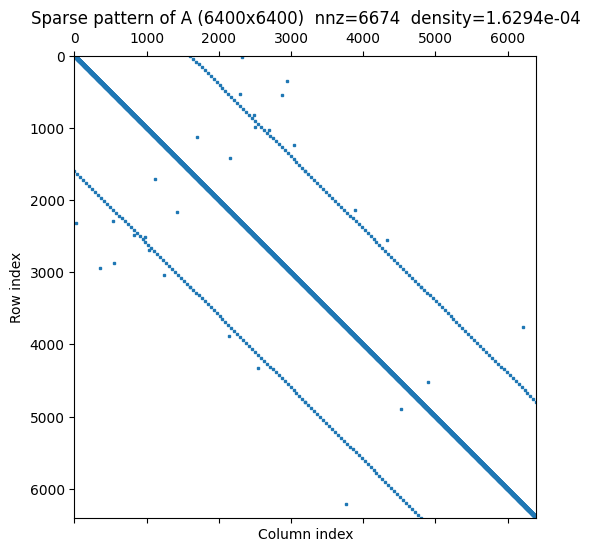

In [ ]:
# Heat map of sparse matrix A (value‑coded non‑zeros)

sparse_A = ham.A if hasattr(ham, "A") else A
if not ss.issparse(sparse_A):
    sparse_A = ss.csr_matrix(sparse_A)

m, n = sparse_A.shape
nnz = sparse_A.nnz
density = nnz / (m * n)

# For large sparse matrices avoid full densification; plot only non‑zeros with value colormap
coo = sparse_A.tocoo()

plt.figure(figsize=(6, 6))
sc = plt.scatter(coo.col, coo.row, c=coo.data, cmap='viridis', s=6, marker='s', linewidths=0)
plt.gca().invert_yaxis()
plt.colorbar(sc, label='Entry value')
plt.title(f"Heat map (non-zeros) of A ({m}x{n})  nnz={nnz}  density={density:.4e}")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.tight_layout()
plt.show()


In [5]:
ham.plot_hamiltonian()

AttributeError: 'SimpleHamiltonian' object has no attribute 'plot_hamiltonian'

In [5]:
metrics_df

ghost_rate_metrics  clone_fraction_metrics  \
0             0.000000                     0.0   
1             0.000000                     0.0   
2             0.000000                     0.0   
3             0.000000                     0.0   
4             0.000000                     0.0   
..                 ...                     ...   
76            0.000000                     0.0   
77            0.000000                     0.0   
78            0.012821                     0.0   
79            0.000000                     0.0   
80            0.012987                     0.0   

    reconstruction_efficiency_metrics  hit_efficiency_metrics  purity_metrics  \
0                              1.0000                1.000000        1.000000   
1                              1.0000                1.000000        1.000000   
2                              1.0000                1.000000        1.000000   
3                              1.0000                1.000000        1.000000   
4                              1.0000                1.000000        1.000000   
..                                ...                     ...             ...   
76                             0.9250                0.712121        1.000000   
77                             0.9250                0.683673        1.000000   
78                             0.9625                0.732500        1.000000   
79                             0.9625                0.755051        1.000000   
80                             0.9500                0.721939        0.997807   

    total_rec_tracks_metrics  total_truth_tracks_metrics ghost_tracks_metrics  \
0                         80                          80                   []   
1                         80                          80                   []   
2                         80                          80                   []   
3                         80                          80                   []   
4                         80                          80                   []   
..                       ...                         ...                  ...   
76                        74                          80                   []   
77                        74                          80                   []   
78                        78                          80                  [0]   
79                        77                          80                   []   
80                        77                          80                 [43]   

    clones_count_metrics  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
..                   ...  
76                     0  
77                     0  
78                     0  
79                     0  
80                     0  

[81 rows x 9 columns]

In [6]:
full = pd.concat([metrics_df, res.drop(columns=['metrics'])], axis=1)

In [7]:
# save metrics_df as a CSV
full.to_csv("metrics.csv", index=False)

In [ ]:
full

ghost_rate_metrics  clone_fraction_metrics  \
0             0.000000                     0.0   
1             0.000000                     0.0   
2             0.000000                     0.0   
3             0.025641                     0.0   
4             0.000000                     0.0   
..                 ...                     ...   
76            0.000000                     0.0   
77            0.025641                     0.0   
78            0.000000                     0.0   
79            0.000000                     0.0   
80            0.025641                     0.0   

    reconstruction_efficiency_metrics  hit_efficiency_metrics  purity_metrics  \
0                                1.00                1.000000        1.000000   
1                                1.00                1.000000        1.000000   
2                                1.00                1.000000        1.000000   
3                                0.95                0.950000        1.000000   
4                                1.00                1.000000        1.000000   
..                                ...                     ...             ...   
76                               1.00                1.000000        1.000000   
77                               0.95                0.954082        1.000000   
78                               1.00                1.000000        1.000000   
79                               1.00                1.000000        0.995833   
80                               0.95                0.948980        1.000000   

    total_rec_tracks_metrics  total_truth_tracks_metrics ghost_tracks_metrics  \
0                         40                          40                   []   
1                         40                          40                   []   
2                         40                          40                   []   
3                         39                          40                 [17]   
4                         40                          40                   []   
..                       ...                         ...                  ...   
76                        40                          40                   []   
77                        39                          40                  [8]   
78                        40                          40                   []   
79                        40                          40                   []   
80                        39                          40                  [5]   

    clones_count_metrics Hit_res Multi_scatter noise_rate efficency_err  \
0                      0       0             0          0           0.0   
1                      0       0             0          0          0.01   
2                      0       0             0          0          0.02   
3                      0       0             0      0.001           0.0   
4                      0       0             0      0.001          0.01   
..                   ...     ...           ...        ...           ...   
76                     0   0.004        0.0004      0.001          0.01   
77                     0   0.004        0.0004      0.001          0.02   
78                     0   0.004        0.0004       0.01           0.0   
79                     0   0.004        0.0004       0.01          0.01   
80                     0   0.004        0.0004       0.01          0.02   

     epsilon  
0   0.000001  
1   0.000001  
2   0.000001  
3   0.000001  
4   0.000001  
..       ...  
76  0.000002  
77  0.000002  
78  0.000002  
79  0.000002  
80  0.000002  

[81 rows x 14 columns]

In [ ]:
print(full.dtypes)

ghost_rate_metrics                   float64
clone_fraction_metrics               float64
reconstruction_efficiency_metrics    float64
hit_efficiency_metrics               float64
purity_metrics                       float64
total_rec_tracks_metrics               int64
total_truth_tracks_metrics             int64
ghost_tracks_metrics                  object
clones_count_metrics                   int64
Hit_res                               object
Multi_scatter                         object
noise_rate                            object
efficency_err                         object
epsilon                               object
dtype: object


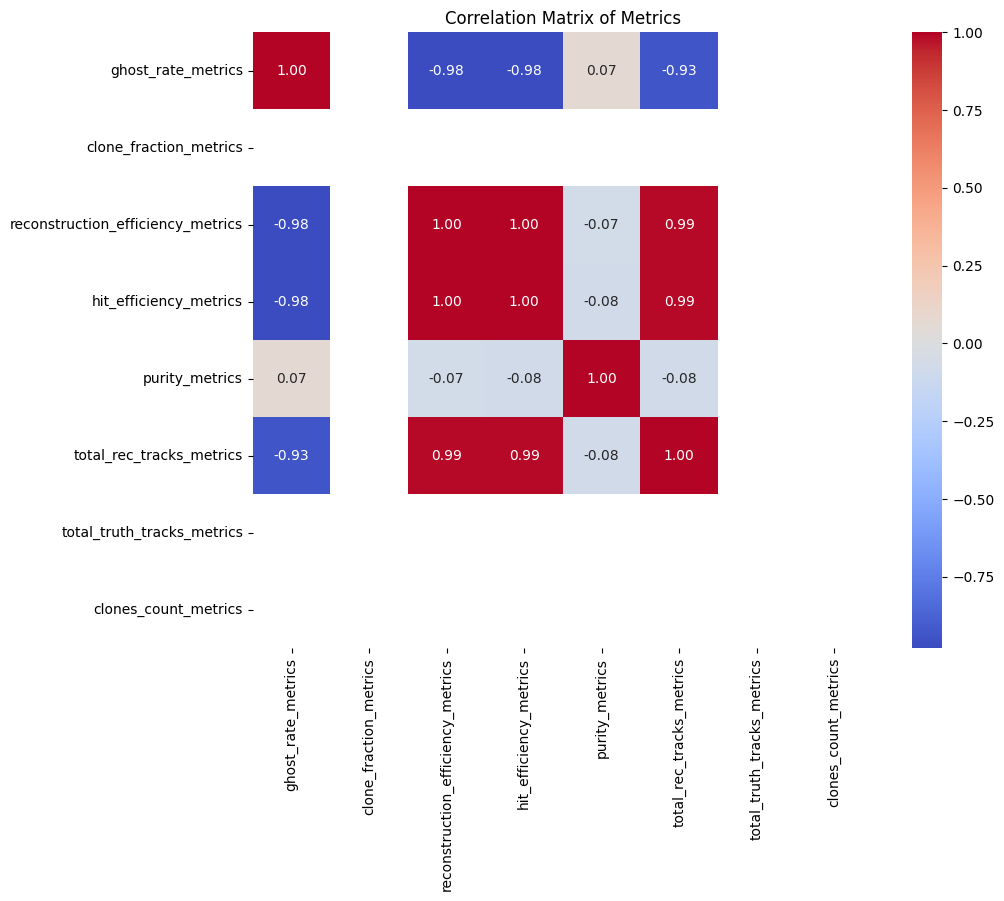

In [ ]:
import seaborn as sns

# Compute the correlation matrix for numeric columns only
corr = full.select_dtypes(include=['float64', 'int64','float32', 'int32']).corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Metrics")
plt.show()